The objective of this notebook is to explore whether RSI, MACD histograms and EMA are good indicators for trend prediction.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
STOCK_PRICE_PATH_2022 = "../../5min_hist_SPY_2022.csv"
STOCK_PRICE_PATH_2023 = "../../5min_hist_SPY_2023.csv"

In [3]:
stock_price_2022_df = pd.read_csv(STOCK_PRICE_PATH_2022)
stock_price_2023_df = pd.read_csv(STOCK_PRICE_PATH_2023)
stock_price_df = pd.concat([stock_price_2022_df, stock_price_2023_df], axis=0)

In [4]:
stock_price_df = stock_price_df.sort_values("date").reset_index(drop=True)

In [5]:
stock_price_df.head()

,date,open,low,high,close,volume
0,2022-01-03 09:30:00,476.30,476.2200,477.170,477.07,1957706
1,2022-01-03 09:35:00,477.08,476.9000,477.720,477.29,1299847
2,2022-01-03 09:40:00,477.27,477.0126,477.439,477.17,747324
3,2022-01-03 09:45:00,477.18,474.5600,477.290,474.89,1887177
4,2022-01-03 09:50:00,474.90,473.8500,475.490,475.03,2393604


In [6]:
def ema(df, span, norm=True):
    df['ema20_open'] = df['open'].ewm(span=span, adjust=False).mean()
    df['ema20_open'] = df['ema20_open'] / df['open']
    df['ema20_close'] = df['close'].ewm(span=span, adjust=False).mean()
    df['ema20_close'] = df['ema20_close'] / df['close']
    return df

stock_price_df = ema(stock_price_df, 20)

# compute 20-EMA
# stock_price_df['ema20_open'] = stock_price_df['open'].ewm(span=20, adjust=False).mean()
# stock_price_df['ema20_close'] = stock_price_df['close'].ewm(span=20, adjust=False).mean()

In [9]:
stock_price_df.head(10)

,date,open,low,high,close,volume,ema20_open,ema20_close
0,2023-01-03 09:30:00,384.37,383.5900,385.12,384.5100,1973684,384.370000,384.510000
1,2023-01-03 09:35:00,384.54,384.3250,385.44,385.3900,961927,384.386190,384.593810
2,2023-01-03 09:40:00,385.41,385.1655,386.43,385.2800,1629742,384.483696,384.659161
3,2023-01-03 09:45:00,385.29,383.0200,385.40,383.5000,1997429,384.560487,384.548765
4,2023-01-03 09:50:00,383.49,382.5000,383.96,382.8001,1800303,384.458536,384.382225
5,2023-01-03 09:55:00,382.80,381.6601,383.10,381.7100,982402,384.300580,384.127728
6,2023-01-03 10:00:00,381.77,381.6800,382.58,382.1200,1600548,384.059572,383.936515
7,2023-01-03 10:05:00,382.12,381.7801,382.41,381.9700,879537,383.874851,383.749228
8,2023-01-03 10:10:00,381.96,380.9300,382.03,381.1650,1236231,383.692484,383.503111
9,2023-01-03 10:15:00,381.18,380.2200,381.37,380.2550,999059,383.453200,383.193767


In [7]:
def compute_rsi(df, col, period: int = 14):
    delta = df[col].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    # Use exponential moving average for smoothing
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

p = 14
stock_price_df['rsi_open'] = compute_rsi(stock_price_df, "open", p)
stock_price_df['rsi_close'] = compute_rsi(stock_price_df, "close", p)

In [7]:
stock_price_df.head(10)

,date,open,low,high,close,volume,ema20_open,ema20_close,rsi_open,rsi_close
0,2023-01-03 09:30:00,384.37,383.5900,385.12,384.5100,1973684,384.370000,384.510000,NaN,NaN
1,2023-01-03 09:35:00,384.54,384.3250,385.44,385.3900,961927,384.386190,384.593810,100.000000,100.000000
2,2023-01-03 09:40:00,385.41,385.1655,386.43,385.2800,1629742,384.483696,384.659161,100.000000,99.047619
3,2023-01-03 09:45:00,385.29,383.0200,385.40,383.5000,1997429,384.560487,384.548765,95.973154,84.948878
4,2023-01-03 09:50:00,383.49,382.5000,383.96,382.8001,1800303,384.458536,384.382225,58.148264,80.119667
5,2023-01-03 09:55:00,382.80,381.6601,383.10,381.7100,982402,384.300580,384.127728,50.011382,73.145078
6,2023-01-03 10:00:00,381.77,381.6800,382.58,382.1200,1600548,384.059572,383.936515,40.827144,74.059731
7,2023-01-03 10:05:00,382.12,381.7801,382.41,381.9700,879537,383.874851,383.749228,44.553336,73.079073
8,2023-01-03 10:10:00,381.96,380.9300,382.03,381.1650,1236231,383.692484,383.503111,43.213658,67.883997
9,2023-01-03 10:15:00,381.18,380.2200,381.37,380.2550,999059,383.453200,383.193767,37.321921,62.477078


In [8]:
def compute_macd(df, col, fl=12, sl=26, signal_length=9):
    # Calculate the fast and slow EMAs
    ema_fast = df[col].ewm(span=fl, adjust=False).mean()
    ema_slow = df[col].ewm(span=sl, adjust=False).mean()

    # MACD Line
    macd_line = ema_fast - ema_slow

    # Signal Line
    signal_line = macd_line.ewm(span=signal_length, adjust=False).mean()

    # MACD Histogram
    macd_hist = macd_line - signal_line

    # Add to DataFrame
    return macd_hist

fl = 12  # Fast length
sl = 26  # Slow length
stock_price_df["macd_hist"] = compute_macd(stock_price_df, "open", fl=fl, sl=sl)

In [11]:
stock_price_df.head(10)

,date,open,low,high,close,volume,ema20_open,ema20_close,rsi_open,rsi_close,macd_hist
0,2023-01-03 09:30:00,384.37,383.5900,385.12,384.5100,1973684,384.370000,384.510000,NaN,NaN,0.000000
1,2023-01-03 09:35:00,384.54,384.3250,385.44,385.3900,961927,384.386190,384.593810,100.000000,100.000000,0.010849
2,2023-01-03 09:40:00,385.41,385.1655,386.43,385.2800,1629742,384.483696,384.659161,100.000000,99.047619,0.072577
3,2023-01-03 09:45:00,385.29,383.0200,385.40,383.5000,1997429,384.560487,384.548765,95.973154,84.948878,0.099614
4,2023-01-03 09:50:00,383.49,382.5000,383.96,382.8001,1800303,384.458536,384.382225,58.148264,80.119667,-0.003951
5,2023-01-03 09:55:00,382.80,381.6601,383.10,381.7100,982402,384.300580,384.127728,50.011382,73.145078,-0.113098
6,2023-01-03 10:00:00,381.77,381.6800,382.58,382.1200,1600548,384.059572,383.936515,40.827144,74.059731,-0.241464
7,2023-01-03 10:05:00,382.12,381.7801,382.41,381.9700,879537,383.874851,383.749228,44.553336,73.079073,-0.286527
8,2023-01-03 10:10:00,381.96,380.9300,382.03,381.1650,1236231,383.692484,383.503111,43.213658,67.883997,-0.308909
9,2023-01-03 10:15:00,381.18,380.2200,381.37,380.2550,999059,383.453200,383.193767,37.321921,62.477078,-0.354765


In [9]:
def compute_future_candles(df, scope={"weeks": 1}):
    # Ensure 'date' column is datetime and sorted
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    future_colnames = ['future_open', 'future_high', 'future_low', 'future_close']
    for col in future_colnames:
        if col in df.columns:
            df = df.drop(columns=[col])

    # Create a new DataFrame to hold the future candles
    future_candles = pd.DataFrame(index=df.index, columns=future_colnames)

    # Set the duration of scope
    defined_scope = timedelta(**scope)

    for i in range(len(df) - 1):
        current_time = df.loc[i, 'date']
        end_time = current_time + defined_scope

        # Get future data for the next 1 week
        mask = (df['date'] > current_time) & (df['date'] <= end_time)
        future_data = df.loc[mask]

        if not future_data.empty:
            future_candles.at[i, 'future_open'] = df.loc[i + 1, 'open']
            future_candles.at[i, 'future_high'] = future_data['high'].max()
            future_candles.at[i, 'future_low'] = future_data['low'].min()
            future_candles.at[i, 'future_close'] = future_data.iloc[-1]['close']
        else:
            # If not enough data, fill with NaN
            future_candles.iloc[i] = [None] * 4

    # Combine original DataFrame and new columns
    scope_key, scope_value = next(iter(scope.items()))
    future_candles[f"max_future_price_{scope_key}_{scope_value}"] = future_candles[[
        "future_open",
        "future_high",
        "future_low",
        "future_close",
    ]].max(axis=1)
    
    df = pd.concat(
        [
            df,
            future_candles[[f"max_future_price_{scope_key}_{scope_value}"]],
        ],
        axis=1
    )

    return df

# compute elements for the following scopes: 1 hour, 2 hours, 4 hours, 1 day, 2 days, 5 days, 1 week, 2 weeks
scope_list = [
    {"hours": 1},
    {"hours": 2},
    {"hours": 4},
    {"days": 1},
    {"days": 2},
    {"days": 5},
    {"weeks": 1},
    {"weeks": 2}
]
for scp in scope_list:
    stock_price_df = compute_future_candles(stock_price_df, scope=scp)

In [95]:
stock_price_df.head()

,date,open,low,high,close,volume,ema20_open,ema20_close,rsi_open,rsi_close,...,max_future_price_days_1,label_max_future_price_days_1,max_future_price_days_2,label_max_future_price_days_2,max_future_price_days_5,label_max_future_price_days_5,max_future_price_weeks_1,label_max_future_price_weeks_1,max_future_price_weeks_2,label_max_future_price_weeks_2
0,2023-01-03 09:30:00,384.37,383.5900,385.12,384.5100,1973684,384.370000,384.510000,NaN,NaN,...,386.43,0,386.43,0,389.25,1,393.7,1,399.1,1
1,2023-01-03 09:35:00,384.54,384.3250,385.44,385.3900,961927,384.386190,384.593810,100.000000,100.000000,...,386.43,0,386.43,0,389.25,1,393.7,1,399.1,1
2,2023-01-03 09:40:00,385.41,385.1655,386.43,385.2800,1629742,384.483696,384.659161,100.000000,99.047619,...,385.4,0,385.88,0,389.25,1,393.7,1,399.1,1
3,2023-01-03 09:45:00,385.29,383.0200,385.40,383.5000,1997429,384.560487,384.548765,95.973154,84.948878,...,384.17,0,385.88,0,389.25,1,393.7,1,399.1,1
4,2023-01-03 09:50:00,383.49,382.5000,383.96,382.8001,1800303,384.458536,384.382225,58.148264,80.119667,...,384.17,0,385.88,0,389.25,1,393.7,1,399.1,1


In [10]:
def compute_slope(df, col: str, n_samples: int):
    slopes = []

    for i in range(len(df)):
        start_idx = max(0, i - n_samples + 1)
        window = df[col].iloc[start_idx:i+1]

        # Handle NaNs: if too many, skip
        if window.isna().sum() > 1 or len(window.dropna()) < 2:
            slopes.append(np.nan)
            continue

        y = window.values
        x = np.arange(len(y))

        # Only keep values where y is not NaN
        mask = ~np.isnan(y)
        x = x[mask]
        y = y[mask]

        # Compute slope using linear regression
        slope, _, _, _, _ = linregress(x, y)
        slopes.append(slope)

    return pd.Series(slopes, index=df.index, name=f'{col}_slope')

all_n_samples = [("1h", 12), ("2h", 12*2), ("4h", 12*4), ("1d", 12*8), ("2d", 12*8*2), ("5d", 12*8*5), ("1w", 12*8*7), ("2w", 12*8*7*2)]
for label, n_samples in all_n_samples:
    for col in ["volume", "rsi_open", "rsi_close", "macd_hist"]:
        stock_price_df[f"{label}_{col}_slope"] = compute_slope(stock_price_df, col, n_samples)

In [11]:
def compute_realized_volat(df):
    df["log_return"] = np.log(
        df["close"] / df["close"].shift(periods=1)
    )

    df['realized_vol_1h'] = df['log_return'].rolling(window=12).std() * np.sqrt(12)
    df['realized_vol_2h'] = df['log_return'].rolling(window=12*2).std() * np.sqrt(12*2)
    df['realized_vol_4h'] = df['log_return'].rolling(window=12*4).std() * np.sqrt(12*4)

    df['realized_vol_1d'] = df['log_return'].rolling(window=12*8).std() * np.sqrt(12*8)
    df['realized_vol_2d'] = df['log_return'].rolling(window=12*8*2).std() * np.sqrt(12*8*2)
    df['realized_vol_5d'] = df['log_return'].rolling(window=12*8*5).std() * np.sqrt(12*8*5)

    df['realized_vol_1w'] = df['log_return'].rolling(window=12*8*7).std() * np.sqrt(12*8*7)
    df['realized_vol_2w'] = df['log_return'].rolling(window=12*8*7*2).std() * np.sqrt(12*8*7*2)
    return df

stock_price_df = compute_realized_volat(stock_price_df)

# Realized Volatility 1 & 2 days 
# stock_price_df["log_return"] = np.log(
#     stock_price_df["close"] / stock_price_df["close"].shift(periods=1)
# )

# stock_price_df['realized_vol_1h'] = stock_price_df['log_return'].rolling(window=12).std() * np.sqrt(12)
# stock_price_df['realized_vol_2h'] = stock_price_df['log_return'].rolling(window=12*2).std() * np.sqrt(12*2)
# stock_price_df['realized_vol_4h'] = stock_price_df['log_return'].rolling(window=12*4).std() * np.sqrt(12*4)

# stock_price_df['realized_vol_1d'] = stock_price_df['log_return'].rolling(window=12*8).std() * np.sqrt(12*8)
# stock_price_df['realized_vol_2d'] = stock_price_df['log_return'].rolling(window=12*8*2).std() * np.sqrt(12*8*2)
# stock_price_df['realized_vol_5d'] = stock_price_df['log_return'].rolling(window=12*8*5).std() * np.sqrt(12*8*5)

# stock_price_df['realized_vol_1w'] = stock_price_df['log_return'].rolling(window=12*8*7).std() * np.sqrt(12*8*7)
# stock_price_df['realized_vol_2w'] = stock_price_df['log_return'].rolling(window=12*8*7*2).std() * np.sqrt(12*8*7*2)

def stochastic_oscllator(df):
    window_sizes = [("1h", 12), ("2h", 12*2), ("4h", 12*4), ("1d", 12*8), ("2d", 12*8*2), ("5d", 12*8*5), ("1w", 12*8*7), ("2w", 12*8*7*2)]
    for label, size in window_sizes:
        low_min = df['low'].rolling(window=size).min()
        high_max = df['high'].rolling(window=size).max()
        df[f'stoch_k_{label}'] = 100 * (df['close'] - low_min) / (high_max - low_min)
    return df

stock_price_df = stochastic_oscllator(stock_price_df)

# Stochastic Oscillator or %K
# window_sizes = [("1h", 12), ("2h", 12*2), ("4h", 12*4), ("1d", 12*8), ("2d", 12*8*2), ("5d", 12*8*5), ("1w", 12*8*7), ("2w", 12*8*7*2)]
# for label, size in window_sizes:
#     low_min = stock_price_df['low'].rolling(window=size).min()
#     high_max = stock_price_df['high'].rolling(window=size).max()
#     stock_price_df[f'stoch_k_{label}'] = 100 * (stock_price_df['close'] - low_min) / (high_max - low_min)

def implied_drift_and_diffusion(df):
    window_sizes = [("1h", 12), ("2h", 12*2), ("4h", 12*4), ("1d", 12*8), ("2d", 12*8*2), ("5d", 12*8*5), ("1w", 12*8*7), ("2w", 12*8*7*2)]
    for label, size in window_sizes:
        df[f'drift_{label}'] = df['log_return'].rolling(window=size).mean()
        df[f'diffusion_{label}'] = df['log_return'].rolling(window=size).std()
    return df

stock_price_df = implied_drift_and_diffusion(stock_price_df)

# Implied Drift and Diffusion
# window_size = 12*8  # 1 hour = 12
# for label, size in window_sizes:
#     stock_price_df[f'drift_{label}'] = stock_price_df['log_return'].rolling(window=size).mean()
#     stock_price_df[f'diffusion_{label}'] = stock_price_df['log_return'].rolling(window=size).std()

def fst_passage_time(df):
    window_sizes = [("1h", 12), ("2h", 12*2), ("4h", 12*4), ("1d", 12*8), ("2d", 12*8*2), ("5d", 12*8*5), ("1w", 12*8*7), ("2w", 12*8*7*2)]
    df['hl_range'] = df['high'] - df['low']
    for label, size in window_sizes:
        df[f'price_range_{label}'] = df['close'].rolling(window=size).apply(lambda x: x.max() - x.min())
    return df

stock_price_df = fst_passage_time(stock_price_df)

# First-Passage Time / Range Features
# stock_price_df['hl_range'] = stock_price_df['high'] - stock_price_df['low']
# for label, size in window_sizes:
#     stock_price_df[f'price_range_{label}'] = stock_price_df['close'].rolling(window=size).apply(lambda x: x.max() - x.min())

# ----------------------------------------------------------------------------
# percentage change between max future price and current rolling average price
# ----------------------------------------------------------------------------

def avg_prices(df):
    df["1h_avg_price"] = df["close"].rolling(window=12).mean()
    df["2h_avg_price"] = df["close"].rolling(window=12*2).mean()
    df["4h_avg_price"] = df["close"].rolling(window=12*4).mean()
    df["1d_avg_price"] = df["close"].rolling(window=12*8).mean()
    df["2d_avg_price"] = df["close"].rolling(window=12*8*2).mean()
    df["5d_avg_price"] = df["close"].rolling(window=12*8*5).mean()
    df["1w_avg_price"] = df["close"].rolling(window=12*8*7).mean()
    df["2w_avg_price"] = df["close"].rolling(window=12*8*7*2).mean()
    return df

stock_price_df = avg_prices(stock_price_df)

# stock_price_df["1h_avg_price"] = stock_price_df["close"].rolling(window=12).mean()
# stock_price_df["2h_avg_price"] = stock_price_df["close"].rolling(window=12*2).mean()
# stock_price_df["4h_avg_price"] = stock_price_df["close"].rolling(window=12*4).mean()
# stock_price_df["1d_avg_price"] = stock_price_df["close"].rolling(window=12*8).mean()
# stock_price_df["2d_avg_price"] = stock_price_df["close"].rolling(window=12*8*2).mean()
# stock_price_df["5d_avg_price"] = stock_price_df["close"].rolling(window=12*8*5).mean()
# stock_price_df["1w_avg_price"] = stock_price_df["close"].rolling(window=12*8*7).mean()
# stock_price_df["2w_avg_price"] = stock_price_df["close"].rolling(window=12*8*7*2).mean()

def compute_labels(df):

    mask_1h = df["1h_avg_price"].notna()
    mask_2h = df["2h_avg_price"].notna()
    mask_4h = df["4h_avg_price"].notna()

    mask_1d = df["1d_avg_price"].notna()
    mask_2d = df["2d_avg_price"].notna()
    mask_5d = df["5d_avg_price"].notna()

    mask_1w = df["1w_avg_price"].notna()
    mask_2w = df["2w_avg_price"].notna()

    df.loc[mask_1h, "label_pct_change_1h_avg_future_max"] = (df.loc[mask_1h, "max_future_price_hours_1"] / df.loc[mask_1h, "1h_avg_price"]) - 1
    df.loc[mask_2h, "label_pct_change_2h_avg_future_max"] = (df.loc[mask_2h, "max_future_price_hours_2"] / df.loc[mask_2h, "2h_avg_price"]) - 1
    df.loc[mask_4h, "label_pct_change_4h_avg_future_max"] = (df.loc[mask_4h, "max_future_price_hours_4"] / df.loc[mask_4h, "4h_avg_price"]) - 1

    df.loc[mask_1d, "label_pct_change_1d_avg_future_max"] = (df.loc[mask_1d, "max_future_price_days_1"] / df.loc[mask_1d, "1d_avg_price"]) - 1
    df.loc[mask_2d, "label_pct_change_2d_avg_future_max"] = (df.loc[mask_2d, "max_future_price_days_2"] / df.loc[mask_2d, "2d_avg_price"]) - 1
    df.loc[mask_5d, "label_pct_change_5d_avg_future_max"] = (df.loc[mask_5d, "max_future_price_days_5"] / df.loc[mask_5d, "5d_avg_price"]) - 1

    df.loc[mask_1w, "label_pct_change_1w_avg_future_max"] = (df.loc[mask_1w, "max_future_price_weeks_1"] / df.loc[mask_1w, "1w_avg_price"]) - 1
    df.loc[mask_2w, "label_pct_change_2w_avg_future_max"] = (df.loc[mask_2w, "max_future_price_weeks_2"] / df.loc[mask_2w, "2w_avg_price"]) - 1

    df["label_pct_change_last_close_1h_avg_future_max"] = (df["max_future_price_hours_1"] / df["close"]) - 1# not close shift since numerator is already the max future price from row + 1
    df["label_pct_change_last_close_2h_avg_future_max"] = (df["max_future_price_hours_2"] / df["close"]) - 1# not close shift since numerator is already the max future price from row + 1
    df["label_pct_change_last_close_4h_avg_future_max"] = (df["max_future_price_hours_4"] / df["close"]) - 1# not close shift since numerator is already the max future price from row + 1

    df["label_pct_change_last_close_1d_avg_future_max"] = (df["max_future_price_days_1"] / df["close"]) - 1# not close shift since numerator is already the max future price from row + 1
    df["label_pct_change_last_close_2d_avg_future_max"] = (df["max_future_price_days_2"] / df["close"]) - 1# not close shift since numerator is already the max future price from row + 1
    df["label_pct_change_last_close_5d_avg_future_max"] = (df["max_future_price_days_5"] / df["close"]) - 1# not close shift since numerator is already the max future price from row + 1

    df["label_pct_change_last_close_1w_avg_future_max"] = (df["max_future_price_weeks_1"] / df["close"]) - 1# not close shift since numerator is already the max future price from row + 1
    df["label_pct_change_last_close_2w_avg_future_max"] = (df["max_future_price_weeks_2"] / df["close"]) - 1# not close shift since numerator is already the max future price from row + 1

    scope_list = [
        {"hours": 1},
        {"hours": 2},
        {"hours": 4},
        {"days": 1},
        {"days": 2},
        {"days": 5},
        {"weeks": 1},
        {"weeks": 2}
    ]
    for scp in scope_list:
        scope_key, scope_value = next(iter(scp.items()))
        df[f"label_max_future_price_{scope_key}_{scope_value}"] = (
            (df[f"max_future_price_{scope_key}_{scope_value}"] / df["close"]) - 1
        ).apply(lambda x: 0 if x <= 0.01 else 1)
    return df

stock_price_df = compute_labels(stock_price_df)

# mask_1h = stock_price_df["1h_avg_price"].notna()
# mask_2h = stock_price_df["2h_avg_price"].notna()
# mask_4h = stock_price_df["4h_avg_price"].notna()

# mask_1d = stock_price_df["1d_avg_price"].notna()
# mask_2d = stock_price_df["2d_avg_price"].notna()
# mask_5d = stock_price_df["5d_avg_price"].notna()

# mask_1w = stock_price_df["1w_avg_price"].notna()
# mask_2w = stock_price_df["2w_avg_price"].notna()

# stock_price_df.loc[mask_1h, "label_pct_change_1h_avg_future_max"] = (stock_price_df.loc[mask_1h, "max_future_price_hours_1"] / stock_price_df.loc[mask_1h, "1h_avg_price"]) - 1
# stock_price_df.loc[mask_2h, "label_pct_change_2h_avg_future_max"] = (stock_price_df.loc[mask_2h, "max_future_price_hours_2"] / stock_price_df.loc[mask_2h, "2h_avg_price"]) - 1
# stock_price_df.loc[mask_4h, "label_pct_change_4h_avg_future_max"] = (stock_price_df.loc[mask_4h, "max_future_price_hours_4"] / stock_price_df.loc[mask_4h, "4h_avg_price"]) - 1

# stock_price_df.loc[mask_1d, "label_pct_change_1d_avg_future_max"] = (stock_price_df.loc[mask_1d, "max_future_price_days_1"] / stock_price_df.loc[mask_1d, "1d_avg_price"]) - 1
# stock_price_df.loc[mask_2d, "label_pct_change_2d_avg_future_max"] = (stock_price_df.loc[mask_2d, "max_future_price_days_2"] / stock_price_df.loc[mask_2d, "2d_avg_price"]) - 1
# stock_price_df.loc[mask_5d, "label_pct_change_5d_avg_future_max"] = (stock_price_df.loc[mask_5d, "max_future_price_days_5"] / stock_price_df.loc[mask_5d, "5d_avg_price"]) - 1

# stock_price_df.loc[mask_1w, "label_pct_change_1w_avg_future_max"] = (stock_price_df.loc[mask_1w, "max_future_price_weeks_1"] / stock_price_df.loc[mask_1w, "1w_avg_price"]) - 1
# stock_price_df.loc[mask_2w, "label_pct_change_2w_avg_future_max"] = (stock_price_df.loc[mask_2w, "max_future_price_weeks_2"] / stock_price_df.loc[mask_2w, "2w_avg_price"]) - 1

# stock_price_df["label_pct_change_last_close_1h_avg_future_max"] = (stock_price_df["max_future_price_hours_1"] / stock_price_df["close"]) - 1# not close shift since numerator is already the max future price from row + 1
# stock_price_df["label_pct_change_last_close_2h_avg_future_max"] = (stock_price_df["max_future_price_hours_2"] / stock_price_df["close"]) - 1# not close shift since numerator is already the max future price from row + 1
# stock_price_df["label_pct_change_last_close_4h_avg_future_max"] = (stock_price_df["max_future_price_hours_4"] / stock_price_df["close"]) - 1# not close shift since numerator is already the max future price from row + 1

# stock_price_df["label_pct_change_last_close_1d_avg_future_max"] = (stock_price_df["max_future_price_days_1"] / stock_price_df["close"]) - 1# not close shift since numerator is already the max future price from row + 1
# stock_price_df["label_pct_change_last_close_2d_avg_future_max"] = (stock_price_df["max_future_price_days_2"] / stock_price_df["close"]) - 1# not close shift since numerator is already the max future price from row + 1
# stock_price_df["label_pct_change_last_close_5d_avg_future_max"] = (stock_price_df["max_future_price_days_5"] / stock_price_df["close"]) - 1# not close shift since numerator is already the max future price from row + 1

# stock_price_df["label_pct_change_last_close_1w_avg_future_max"] = (stock_price_df["max_future_price_weeks_1"] / stock_price_df["close"]) - 1# not close shift since numerator is already the max future price from row + 1
# stock_price_df["label_pct_change_last_close_2w_avg_future_max"] = (stock_price_df["max_future_price_weeks_2"] / stock_price_df["close"]) - 1# not close shift since numerator is already the max future price from row + 1

# for scp in scope_list:
#     scope_key, scope_value = next(iter(scp.items()))
#     stock_price_df[f"label_max_future_price_{scope_key}_{scope_value}"] = (
#         (stock_price_df[f"max_future_price_{scope_key}_{scope_value}"] / stock_price_df["close"]) - 1
#     ).apply(lambda x: 0 if x <= 0.01 else 1)

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/1470572657.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["label_pct_change_last_close_5d_avg_future_max"] = (df["max_future_price_days_5"] / df["close"]) - 1# not close shift since numerator is already the max future price from row + 1
/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/1470572657.py:140: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["label_pct_change_last_close_1w_avg_future_max"] = (df["max_future_price_weeks_1"] / df["

In [12]:
def stochastic_features(df):
    window_sizes = [("1h", 12), ("2h", 12*2), ("4h", 12*4), ("1d", 12*8), ("2d", 12*8*2), ("5d", 12*8*5), ("1w", 12*8*7), ("2w", 12*8*7*2)]
    for label, size in window_sizes:
        
        rolling_cols = df[["high", "log_return"]].rolling(window=size)
        max_rolling_high = rolling_cols["high"].max()
        df[f'recent_high_{label}'] = max_rolling_high / df['high']# df['high'].rolling(window=size).max()
        df[f'breakout_attempt_{label}'] = (df['close'] > df[f'recent_high_{label}'].shift(1)).astype(int)

        df[f'dist_from_{label}_high'] = (df['close'] - max_rolling_high) / df['close'] # df['high'].rolling(window=size).max()

        df[f'cum_return_{label}'] = df['close'] / df['close'].shift(size) - 1  # 1-hour return

        df[f'rolling_skew_{label}'] = rolling_cols["log_return"].skew() # df['log_return'].rolling(window=size).skew()
        df[f'rolling_kurtosis_{label}'] = rolling_cols["log_return"].kurt() # df['log_return'].rolling(window=size).kurt()
    return df

stock_price_df = stochastic_features(stock_price_df)

# for label, size in window_sizes:

#     rolling_cols = stock_price_df[["high", "log_return"]].rolling(window=size)
#     max_rolling_high = rolling_cols["high"].max()
#     stock_price_df[f'recent_high_{label}'] = max_rolling_high # stock_price_df['high'].rolling(window=size).max()
#     stock_price_df[f'breakout_attempt_{label}'] = (stock_price_df['close'] > stock_price_df[f'recent_high_{label}'].shift(1)).astype(int)

#     stock_price_df[f'dist_from_{label}_high'] = stock_price_df['close'] - max_rolling_high # stock_price_df['high'].rolling(window=size).max()

#     stock_price_df[f'cum_return_{label}'] = stock_price_df['close'] / stock_price_df['close'].shift(size) - 1  # 1-hour return

#     stock_price_df[f'rolling_skew_{label}'] = rolling_cols["log_return"].skew() # stock_price_df['log_return'].rolling(window=size).skew()
#     stock_price_df[f'rolling_kurtosis_{label}'] = rolling_cols["log_return"].kurt() # stock_price_df['log_return'].rolling(window=size).kurt()


/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/3965548942.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'recent_high_{label}'] = max_rolling_high / df['high']# df['high'].rolling(window=size).max()
/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/3965548942.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'breakout_attempt_{label}'] = (df['close'] > df[f'recent_high_{label}'].shift(1)).astype(int)
/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/3965548942.py:10:

In [25]:
len(stock_price_df.columns)

173

In [26]:
"""
label_pct_change_{something}_avg_future_max -> percentage change between the avg future max price and the current rolling average price (rolling frequency of 'something') -> float
label_pct_change_last_close_{something}_avg_future_max -> percentage change between the avg future max price and the current close price -> float
label_max_future_price_{scope_key}_{scope_value} -> binary label indicating if the max future price is greater than the current close price by more than 1% -> int
"""
len([col for col in stock_price_df.columns if ("1h" in col) or ("label_pct_change_" in col) or ("label_pct_change_last_close_" in col) or ("label_max_future_price_" in col)])

40

In [13]:
def scale_features(df, feature_cols, vals_per_col={}):
    """
    Scale the specified features in the DataFrame using Min-Max scaling.
    """
    df_scaled = df.copy()

    for col in feature_cols:
        if col in df_scaled.columns:
            if col not in vals_per_col:
                if "breakout_attempt" in col:
                    min_val, max_val = 0.0, 1.0
                else:
                    min_val = df_scaled[col].min()
                    max_val = df_scaled[col].max()
                    vals_per_col[col] = (min_val, max_val)                
            else:
                min_val, max_val = vals_per_col[col]
            df_scaled[col] = (df_scaled[col] - min_val) / (max_val - min_val)
    return df_scaled, vals_per_col

In [14]:
GOLBAL_HARD_BEST_THR = 0.7

In [15]:
cols_to_scale = list(
    [
        col for col in stock_price_df.columns if 
        (col in ['volume','ema20_open','ema20_close','rsi_open','rsi_close','macd_hist']) or 
        (
            ("1h" in col or "2h" in col) and ("1h_avg_price" not in col) and 
            ("2h_avg_price" not in col) and ("label" not in col) and ("future" not in col)
        )
    ]
)

labels = [
    "label_pct_change_1h_avg_future_max", # continuous
    "label_pct_change_2h_avg_future_max", # continuous
    "label_pct_change_4h_avg_future_max", # continuous
    "label_pct_change_1d_avg_future_max", # continuous
    "label_pct_change_2d_avg_future_max", # continuous
    "label_pct_change_5d_avg_future_max", # continuous
    "label_pct_change_1w_avg_future_max", # continuous
    "label_pct_change_2w_avg_future_max", # continuous
    "label_pct_change_last_close_1h_avg_future_max", # continuous
    "label_pct_change_last_close_2h_avg_future_max", # continuous
    "label_pct_change_last_close_4h_avg_future_max", # continuous
    "label_pct_change_last_close_1d_avg_future_max", # continuous
    "label_pct_change_last_close_2d_avg_future_max", # continuous
    "label_pct_change_last_close_5d_avg_future_max", # continuous
    "label_pct_change_last_close_1w_avg_future_max", # continuous
    "label_pct_change_last_close_2w_avg_future_max", # continuous
    "label_max_future_price_hours_1", # bool
    "label_max_future_price_hours_2", # bool
    "label_max_future_price_hours_4", # bool
    "label_max_future_price_days_1", # bool
    "label_max_future_price_days_2", # bool
    "label_max_future_price_days_5", # bool
    "label_max_future_price_weeks_1", # bool
    "label_max_future_price_weeks_2", # bool
]

In [89]:
cols_to_scale

['volume',
 'ema20_open',
 'ema20_close',
 'rsi_open',
 'rsi_close',
 'macd_hist',
 '1h_volume_slope',
 '1h_rsi_open_slope',
 '1h_rsi_close_slope',
 '1h_macd_hist_slope',
 '2h_volume_slope',
 '2h_rsi_open_slope',
 '2h_rsi_close_slope',
 '2h_macd_hist_slope',
 'realized_vol_1h',
 'realized_vol_2h',
 'stoch_k_1h',
 'stoch_k_2h',
 'drift_1h',
 'diffusion_1h',
 'drift_2h',
 'diffusion_2h',
 'price_range_1h',
 'price_range_2h',
 'recent_high_1h',
 'breakout_attempt_1h',
 'dist_from_1h_high',
 'cum_return_1h',
 'rolling_skew_1h',
 'rolling_kurtosis_1h',
 'recent_high_2h',
 'breakout_attempt_2h',
 'dist_from_2h_high',
 'cum_return_2h',
 'rolling_skew_2h',
 'rolling_kurtosis_2h']

In [16]:
target_colname = "label_pct_change_1h_avg_future_max"
categorical_cols = [col for col in cols_to_scale if "breakout_attempt" in col]
task  = "regression"

stock_price_df = stock_price_df.sort_values("date")

label_mask = stock_price_df[cols_to_scale + [target_colname]].notna().all(axis=1)
X, y = stock_price_df.loc[label_mask, ['date'] + cols_to_scale], stock_price_df.loc[label_mask, [target_colname]]

if y[target_colname].dtype not in (int, float, bool):
    if task == "classification":
        y[target_colname] = y[target_colname].astype(int)
    elif task == "regression":
        y[target_colname] = y[target_colname].astype(float)

In [17]:
samples_len = len(X)
cutoff_reg_classif = samples_len // 3
cutoff_classif_calib = 2 * samples_len // 3
Xs1, ys1 = X.iloc[:cutoff_reg_classif], y.iloc[:cutoff_reg_classif]
Xs2, ys2 = X.iloc[cutoff_reg_classif:cutoff_classif_calib], y.iloc[cutoff_reg_classif:cutoff_classif_calib]
Xs3, ys3 = X.iloc[cutoff_classif_calib:], y.iloc[cutoff_classif_calib:]

Xs1, vals_per_col = scale_features(Xs1, cols_to_scale)
Xs2, _ = scale_features(Xs2, cols_to_scale, vals_per_col)
Xs3, _ = scale_features(Xs3, cols_to_scale, vals_per_col)

In [18]:
# carry out parameters optimization for RandomForestRegressor
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from sklearn.model_selection import TimeSeriesSplit

# rfreg = RandomForestRegressor()
rfreg = XGBRegressor()
# search_spaces = {
#     'n_estimators': (100, 500),
#     'max_depth': (2, 6),
#     'min_samples_leaf': (10, 20, 30, 50, 100),
#     'max_features': ['sqrt', 'log2', 1.0],
# }
search_spaces = {
    'n_estimators': (100, 500),
    'max_depth': (2, 6),
    'eta': (0.01, 1),
    'subsample': (0.5, 1),
    # 'scale_pos_weight': (1, 30),
}
rf_search = BayesSearchCV(
    rfreg,
    search_spaces=search_spaces,
    n_iter=30,
    cv=TimeSeriesSplit(n_splits=6),
    scoring='neg_mean_squared_error',
    random_state=42,
)
rf_search.fit(Xs1.drop(columns=["date"]), ys1[target_colname])
print("Best parameters for RandomForestRegressor:", rf_search.best_params_)
# best score
print("Best score for RandomForestRegressor:", -rf_search.best_score_)


Best parameters for RandomForestRegressor: OrderedDict({'eta': 0.013594004182195795, 'max_depth': 5, 'n_estimators': 397, 'subsample': 0.6272771289320225})
Best score for RandomForestRegressor: 1.1018257354379718e-05


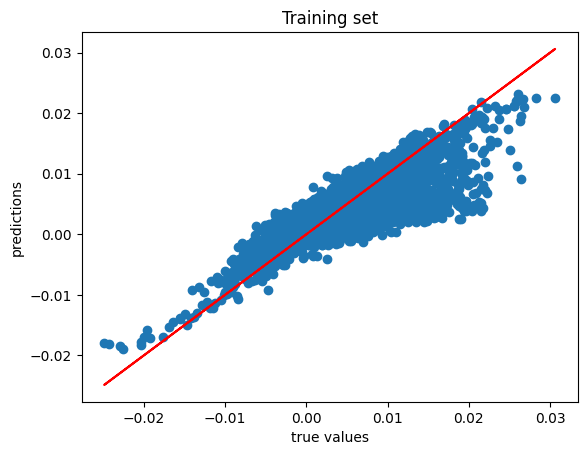

In [19]:
best_params_ = rf_search.best_params_
best_params_.update({"random_state": 42})

rfreg_best_params = XGBRegressor(
    **best_params_
)

rfreg_best_params.fit(Xs1.drop(columns=["date"]), ys1[target_colname])
y_train_predrf = rfreg_best_params.predict(Xs1.drop(columns=["date"]))
y_train_predrf_df = pd.DataFrame(y_train_predrf, index=Xs1.index, columns=["prediction"])

plt.scatter(ys1[target_colname], y_train_predrf)
plt.plot(ys1[target_colname], ys1[target_colname], color="red")
plt.title("Training set")
plt.xlabel("true values")
plt.ylabel("predictions")
None;

In [20]:
from typing import Dict
from xgboost import QuantileDMatrix, train, DMatrix

evals_result: Dict[str, Dict] = {}

Xy = QuantileDMatrix(Xs1.drop(columns=["date"]), ys1[target_colname])
Xy_test = QuantileDMatrix(Xs2.drop(columns=["date"]), ys2[target_colname], ref=Xy)

quantile = 0.25
rf_search_10 = train(
    {
        "objective": "reg:quantileerror",
        "tree_method": "hist",
        "quantile_alpha": quantile,
        'eta': rf_search.best_params_["eta"],
        'max_depth': rf_search.best_params_["max_depth"],
        'subsample': rf_search.best_params_["subsample"],
    },
    Xy,
    num_boost_round=222,
    early_stopping_rounds=2,
    evals=[(Xy, "Train"), (Xy_test, "Test")],
    evals_result=evals_result,
    verbose_eval=0
)

quantile = 0.9
rf_search_90 = train(
    {
        "objective": "reg:quantileerror",
        "tree_method": "hist",
        "quantile_alpha": quantile,
        'eta': rf_search.best_params_["eta"],
        'max_depth': rf_search.best_params_["max_depth"],
        'subsample': rf_search.best_params_["subsample"],
    },
    Xy,
    num_boost_round=222,
    early_stopping_rounds=2,
    evals=[(Xy, "Train"), (Xy_test, "Test")],
    evals_result=evals_result,
    verbose_eval=0,
)
# scores = rf_search_90.predict(DMatrix(Xs2.drop(columns=["date"])))

Text(0, 0.5, 'predictions')

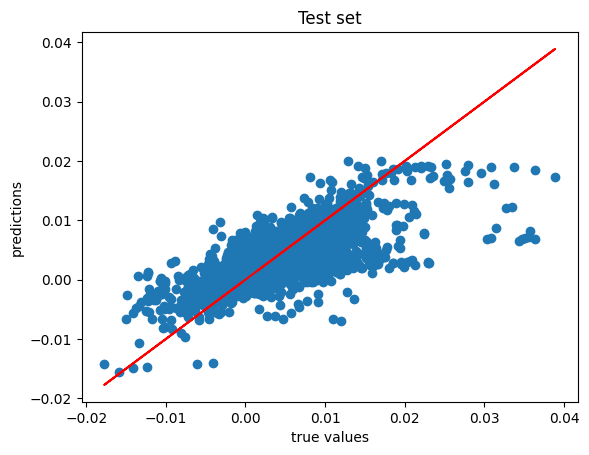

In [21]:
y_predrf_10 = rf_search_10.predict(DMatrix(Xs2.drop(columns=["date"])))
y_predrf_90 = rf_search_90.predict(DMatrix(Xs2.drop(columns=["date"])))
y_predrf_10_df = pd.DataFrame(y_predrf_10, index=Xs2.index, columns=["prediction"])
y_predrf_90_df = pd.DataFrame(y_predrf_90, index=Xs2.index, columns=["prediction"])

y_predrf = rfreg_best_params.predict(Xs2.drop(columns=["date"]))
y_predrf_df = pd.DataFrame(y_predrf, index=Xs2.index, columns=["prediction"])

plt.scatter(ys2[target_colname], y_predrf)
plt.plot(ys2[target_colname], ys2[target_colname], color="red")
plt.title("Test set")
plt.xlabel("true values")
plt.ylabel("predictions")

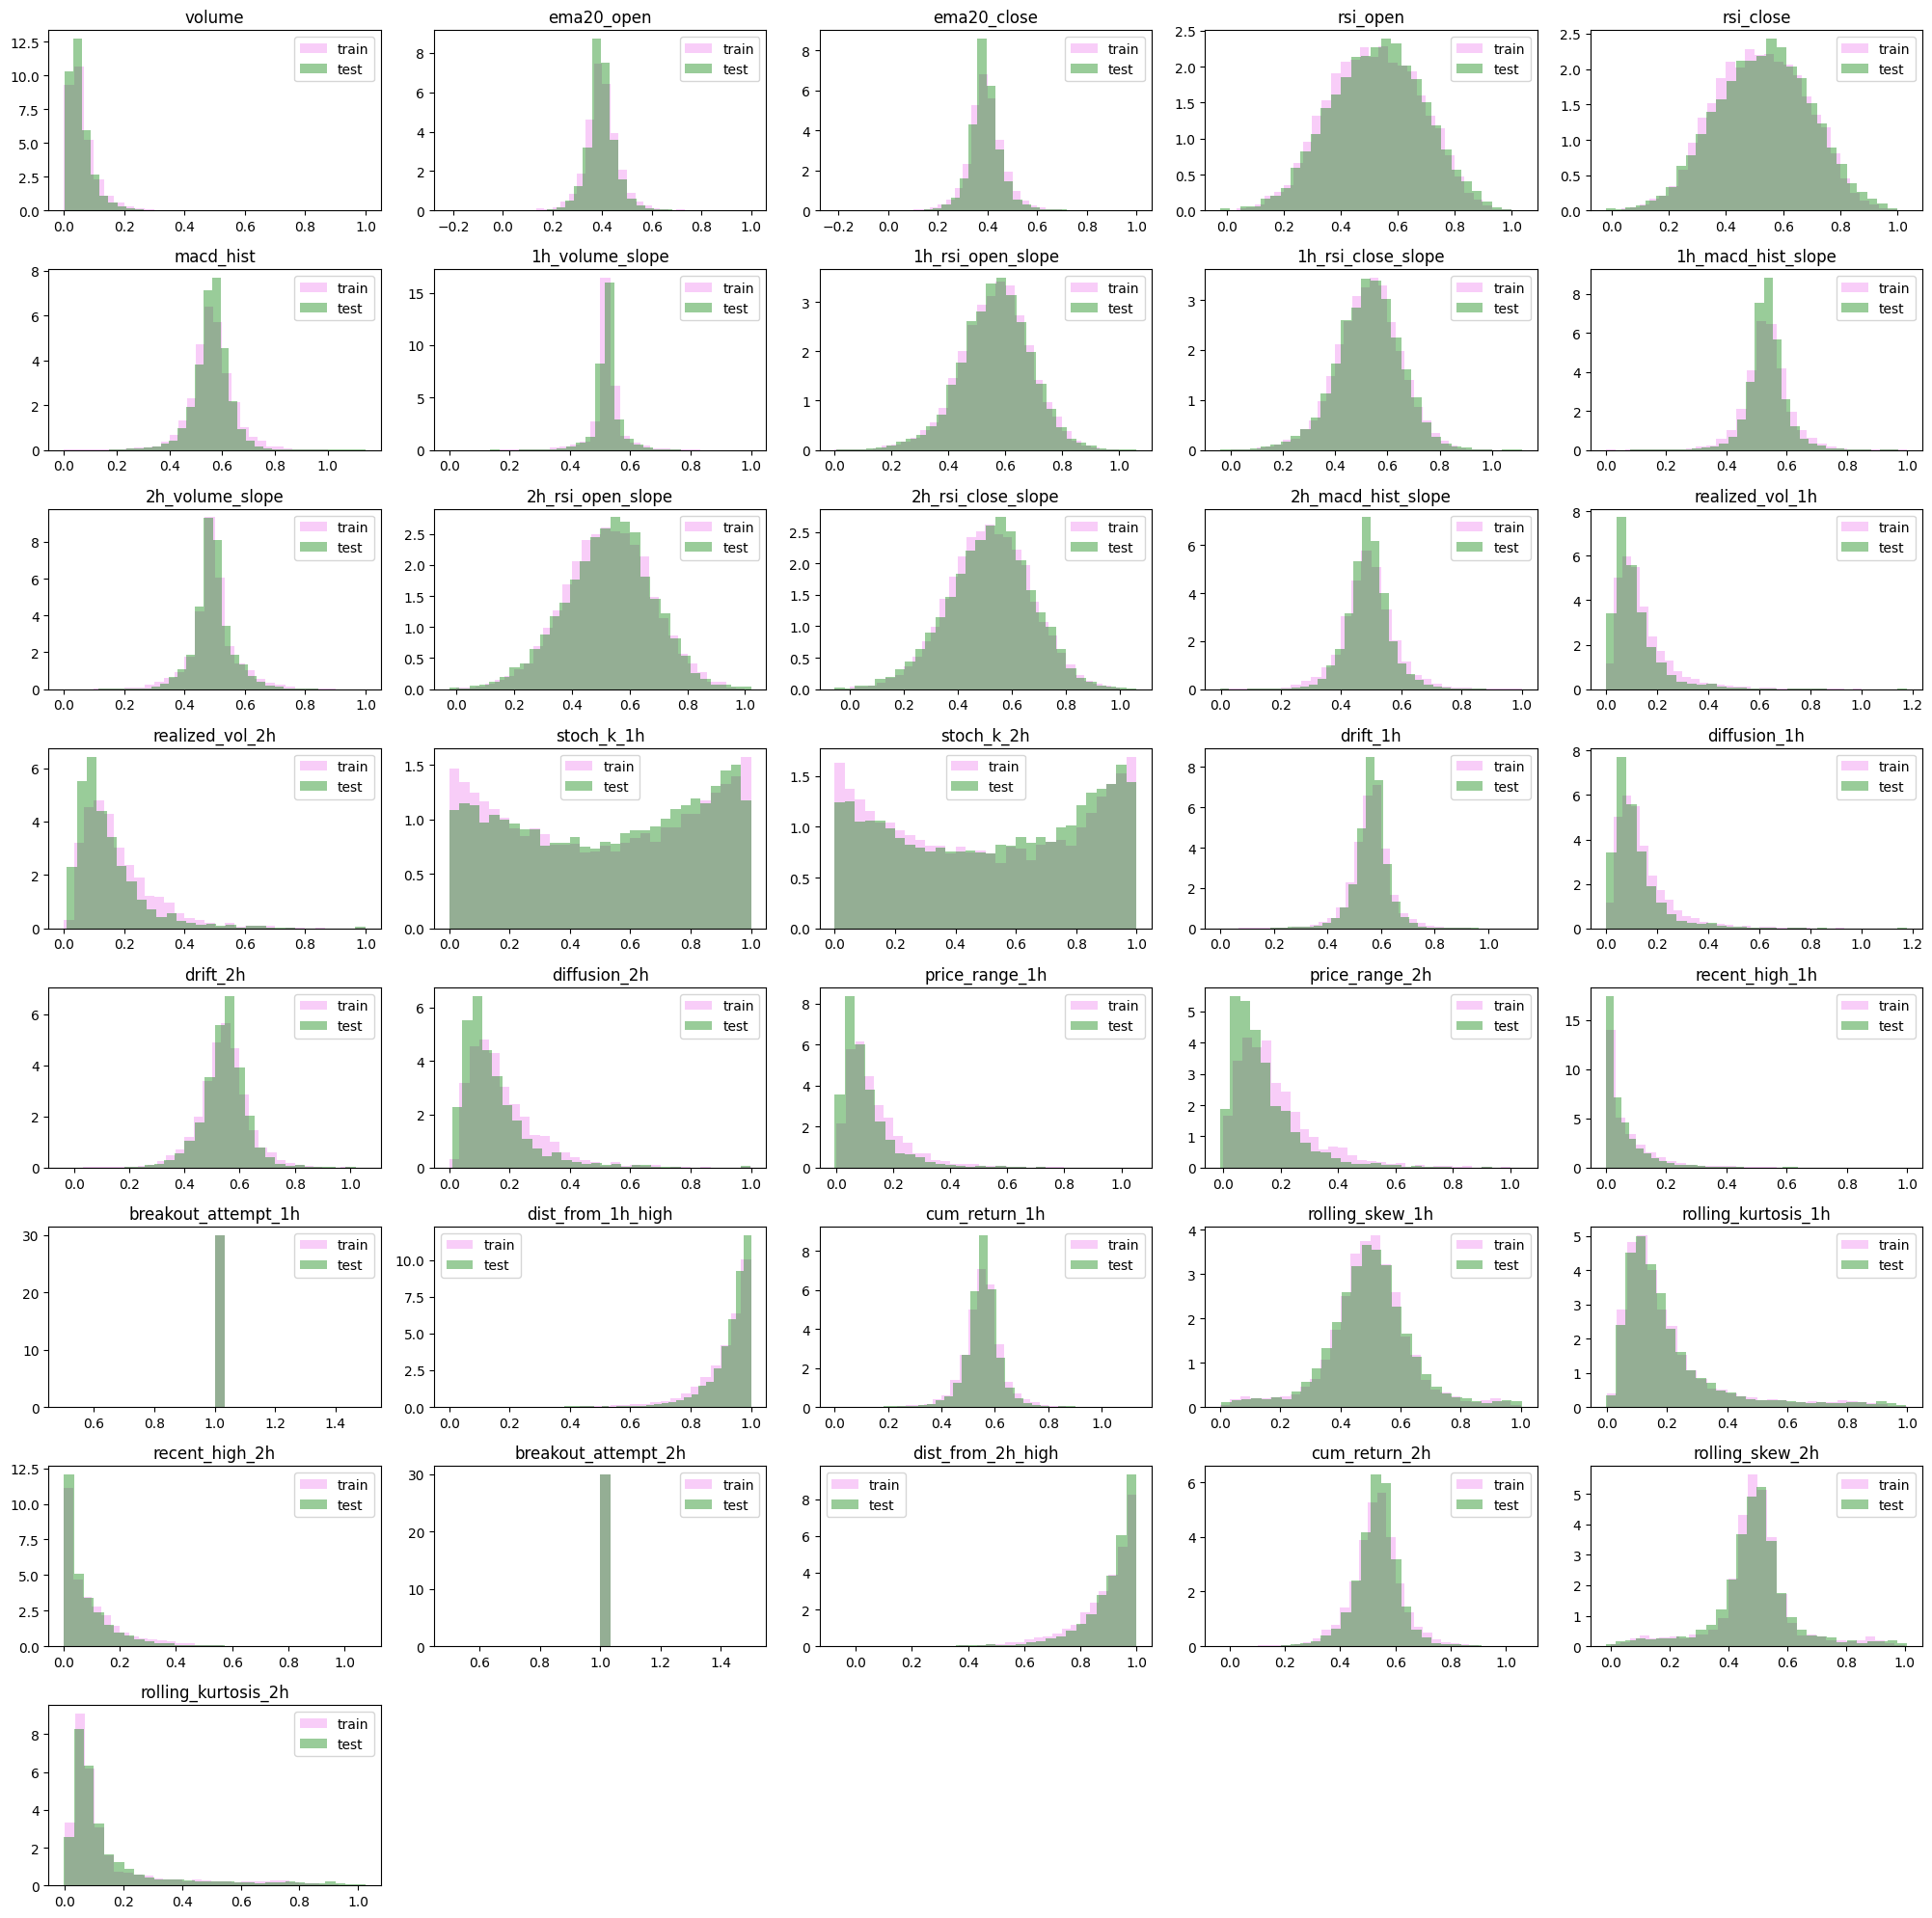

In [22]:
# the predictions of the regressor are poorer in the future test dataset
# let's look at some of the variable distributions to identify potential
# sources of mismatch
# Set up 5x5 grid
fig, axes = plt.subplots(len(cols_to_scale) // 5 + min(1, len(cols_to_scale) % 5), 5, figsize=(20, 20))
axes = axes.flatten()  # Flatten to easily index

# Plot histograms for each column
for i, col in enumerate(cols_to_scale):
    try:
        axes[i].hist(Xs1[col], bins=30, color="violet", alpha=0.4, label="train", density=True)
        axes[i].hist(Xs2[col], bins=30, color="green", alpha=0.4, label="test", density=True)
        axes[i].set_title(col)
        axes[i].legend()
    except:
        print(col)

# Hide any unused axes
for j in range(len(cols_to_scale), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

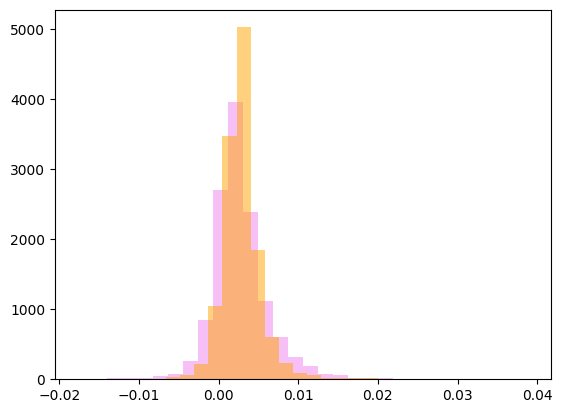

In [23]:
fig, ax = plt.subplots()
ax.hist(ys2[target_colname], bins=30, color="violet", alpha=0.5)
ax.hist(y_predrf, bins=20, color="orange", alpha=0.5);

In [24]:
# MAE on predictions > 0.006
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

thr = 0.006
condition = ys2[target_colname] >= thr
top_sample_values = ys2.loc[condition, target_colname]

top_sample_predictions = y_predrf_df.loc[condition, "prediction"]
mae = mean_absolute_error(top_sample_values, top_sample_predictions)
mape = mean_absolute_percentage_error(top_sample_values, top_sample_predictions)
avg_true_val = ys2.loc[condition, target_colname].mean().item()
# compare mae to average prediction (where predictions > 0.006)
print("mae for samples with predictions over 0.006: ", mae)
print("avg true val for samples with predictions over 0.006: ", avg_true_val)
print("mape for samples with predictions over 0.006: ", mape)

mae for samples with predictions over 0.006:  0.0039985346688391375
avg true val for samples with predictions over 0.006:  0.009338221213952091
mape for samples with predictions over 0.006:  0.41158380045563203


In [25]:
# MAE on samples where y_pred is in top 5%, 1%, .1%

thr95 = y_predrf_df["prediction"].quantile(0.95)
cond95 = y_predrf_df["prediction"] > thr95
top95_sample_predictions = y_predrf_df.loc[cond95, "prediction"]
top95_sample_values = ys2.loc[cond95, target_colname]
mae95 = mean_absolute_error(top95_sample_values, top95_sample_predictions)
mape95 = mean_absolute_percentage_error(top95_sample_values, top95_sample_predictions)
avg_true_val95 = ys2.loc[cond95, target_colname].mean().item()

thr99 = y_predrf_df["prediction"].quantile(0.99)
cond99 = y_predrf_df["prediction"] > thr99
top99_sample_predictions = y_predrf_df.loc[cond99, "prediction"]
top99_sample_values = ys2.loc[cond99, target_colname]
mae99 = mean_absolute_error(top99_sample_values, top99_sample_predictions)
mape99 = mean_absolute_percentage_error(top99_sample_values, top99_sample_predictions)
avg_true_val99 = ys2.loc[cond99, target_colname].mean().item()

thr995 = y_predrf_df["prediction"].quantile(0.995)
cond995 = y_predrf_df["prediction"] > thr995
top995_sample_predictions = y_predrf_df.loc[cond995, "prediction"]
top995_sample_values = ys2.loc[cond995, target_colname]
mae995 = mean_absolute_error(top995_sample_values, top995_sample_predictions)
mape995 = mean_absolute_percentage_error(top995_sample_values, top995_sample_predictions)
avg_true_val995 = ys2.loc[cond995, target_colname].mean().item()

print("mae values for quantiles 95, 99 and 99.5 respectively: ", mae95, mae99, mae995)
print("true means for quantiles 95, 99 and 99.5 respectively: ", avg_true_val95, avg_true_val99, avg_true_val995)
print("mape values for quantiles 95, 99 and 99.5 respectively: ", mape95, mape99, mape995)

mae values for quantiles 95, 99 and 99.5 respectively:  0.0032052881705113127 0.0039102886082788176 0.004625814359872228
true means for quantiles 95, 99 and 99.5 respectively:  0.009872295749415689 0.01580243474048813 0.01849885432343068
mape values for quantiles 95, 99 and 99.5 respectively:  2.1281373608420067 0.23828574212598036 0.24538531522292772


In [26]:
# Overestimation rate: % of cases where y_pred > y_true
overestimation_rate95 = (y_predrf_df.loc[cond95, "prediction"] > ys2.loc[cond95, target_colname]).sum(axis=0) / len(y_predrf_df.loc[cond95])
overestimation_rate99 = (y_predrf_df.loc[cond99, "prediction"] > ys2.loc[cond99, target_colname]).sum(axis=0) / len(y_predrf_df.loc[cond99])
overestimation_rate995 = (y_predrf_df.loc[cond995, "prediction"] > ys2.loc[cond995, target_colname]).sum(axis=0) / len(y_predrf_df.loc[cond995])

print(
    "overestimation_rate for above quatile 0.95: ", overestimation_rate95, "\n"
    "overestimation_rate for above quatile 0.99: ", overestimation_rate99, "\n"
    "overestimation_rate for above quatile 0.995: ", overestimation_rate995,
)

overestimation_rate for above quatile 0.95:  0.5352112676056338 
overestimation_rate for above quatile 0.99:  0.5234375 
overestimation_rate for above quatile 0.995:  0.53125


In [27]:
# mae over avg prediction
print("mae / avg average predicted return for above quantile 0.95: ", mae95 / avg_true_val95)
print("mae / avg average predicted return for above quantile 0.99: ", mae99 / avg_true_val99)
print("mae / avg average predicted return for above quantile 0.995: ", mae995 / avg_true_val995)

mae / avg average predicted return for above quantile 0.95:  0.32467505551593956
mae / avg average predicted return for above quantile 0.99:  0.24744848958370264
mae / avg average predicted return for above quantile 0.995:  0.2500595052534234


In [28]:
# Mean predicted vs. mean true return
print("mean prediction and value for quantile 0.95 respectively: ", end=" ")
print(y_predrf_df.loc[cond95, "prediction"].mean().item(), ys2.loc[cond95, target_colname].mean().item())
print("mean prediction and value for quantile 0.99 respectively: ", end=" ")
print(y_predrf_df.loc[cond99, "prediction"].mean().item(), ys2.loc[cond99, target_colname].mean().item())
print("mean prediction and value for quantile 0.995 respectively: ", end=" ")
print(y_predrf_df.loc[cond995, "prediction"].mean().item(), ys2.loc[cond995, target_colname].mean().item())

mean prediction and value for quantile 0.95 respectively:  0.009451777674257755 0.009872295749415689
mean prediction and value for quantile 0.99 respectively:  0.014410540461540222 0.01580243474048813
mean prediction and value for quantile 0.995 respectively:  0.016807306557893753 0.01849885432343068


In [71]:
# classifier to filter high risky predictions
thr = 0.006
# label = 1 if there is no overestimation
condition = y_predrf_df["prediction"] > thr
sub_Xs2 = Xs2.loc[condition]
sub_ys2 = ys2.loc[condition]
sub_y_predrf_df = y_predrf_df.loc[condition]
sub_y_predrf_10_df = y_predrf_10_df.loc[condition]
sub_y_predrf_90_df = y_predrf_90_df.loc[condition]

sub_ys2["label"] = 0
sub_ys2.loc[sub_y_predrf_df["prediction"] <= sub_ys2[target_colname], "label"] = 1

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/2953226844.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_ys2["label"] = 0


In [93]:
# --------------------------------
# --------------------------------
sub_ys2.loc[sub_y_predrf_10_df["prediction"] > 0.007, target_colname].min()

np.float64(0.006035665220222031)

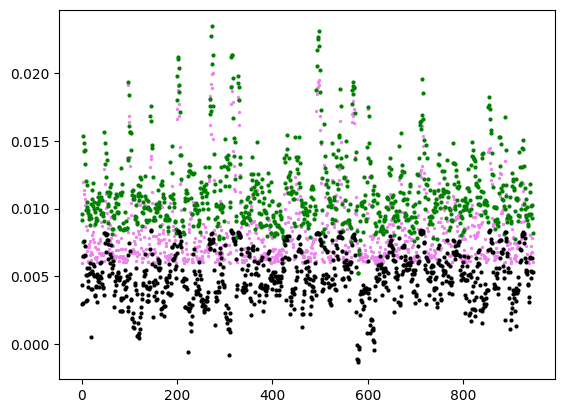

In [68]:
_, ax = plt.subplots()
ax.scatter(range(len(sub_y_predrf_df)), sub_y_predrf_df["prediction"], color="violet", s=2)
ax.scatter(range(len(sub_y_predrf_90_df)), sub_y_predrf_90_df["prediction"], color="green", s=4)
ax.scatter(range(len(sub_y_predrf_10_df)), sub_y_predrf_10_df["prediction"], color="k", s=4)

In [31]:
np.mean((sub_ys2[target_colname] >= sub_y_predrf_10_df["prediction"]) & (sub_ys2[target_colname] <= sub_y_predrf_90_df["prediction"])).item().__round__(2)

0.66

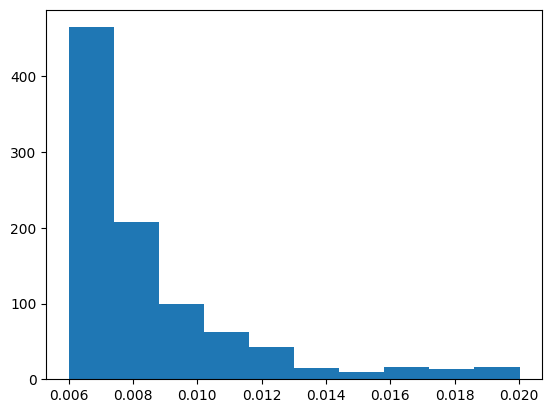

In [32]:
plt.hist(sub_y_predrf_df);

In [72]:
import scipy.stats as stats

quantile_rank = stats.rankdata(y_predrf_df["prediction"], method='average') / len(y_predrf_df["prediction"])
quantile_rank_df = pd.DataFrame(quantile_rank, index=y_predrf_df.index, columns=["quantile_rank"])
sub_quantile_rank_df = quantile_rank_df.loc[condition]

sub_Xs2["orig_prediction"] = sub_y_predrf_df["prediction"]
sub_Xs2["quantile_rank"] = sub_quantile_rank_df["quantile_rank"]
# sub_Xs2["percent_10_vs_avg"] = (sub_y_predrf_10_df["prediction"] - sub_y_predrf_df["prediction"]) / sub_y_predrf_df["prediction"]
# sub_Xs2["percent_90_vs_avg"] = (sub_y_predrf_90_df["prediction"] - sub_y_predrf_df["prediction"]) / sub_y_predrf_df["prediction"]

# sub_Xs2["interval_width"] = sub_y_predrf_90_df["prediction"] - sub_y_predrf_10_df["prediction"]
# sub_Xs2["distance_to_lower"] = sub_y_predrf_df["prediction"] - sub_y_predrf_10_df["prediction"]
# sub_Xs2["distance_to_upper"] = sub_y_predrf_90_df["prediction"] - sub_y_predrf_df["prediction"]
# sub_Xs2["quantile_confidence"] = (sub_y_predrf_df["prediction"] - sub_y_predrf_10_df["prediction"]) / (sub_y_predrf_90_df["prediction"] - sub_y_predrf_10_df["prediction"])


/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/2985974954.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_Xs2["orig_prediction"] = sub_y_predrf_df["prediction"]
/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/2985974954.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_Xs2["quantile_rank"] = sub_quantile_rank_df["quantile_rank"]


In [73]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score

rfclassif = XGBClassifier()

def custom_scorer(estimator, X, y, beta=0.4):
    y_preds = estimator.predict(X)
    recall_score_0 = recall_score(y, y_preds, zero_division=0, pos_label=0)
    precision_score_1 = precision_score(y, y_preds, zero_division=0, pos_label=1)
    denominator = (beta**2 * precision_score_1 + recall_score_0)
    if denominator == 0:
        return 0
    else:
        return (1 + beta**2) * recall_score_0 * precision_score_1 / denominator
    
search_spaces = {
    'n_estimators': (100, 500),
    'max_depth': (2, 6),
    'eta': (0.01, 1),
    'subsample': (0.5, 1),
    'scale_pos_weight': (1, 30),
    'reg_alpha': (0, 5),
    'reg_lambda': (0, 5),
    'min_child_weight': (1, 10),
}
rfclassif_search = BayesSearchCV(
    rfclassif,
    search_spaces=search_spaces,
    n_iter=30,
    cv=TimeSeriesSplit(n_splits=6),
    scoring=custom_scorer,
    random_state=42,
)

rfclassif_search.fit(sub_Xs2.drop(columns=["date"]), sub_ys2["label"])
print("Best parameters for RF Classifier:", rfclassif_search.best_params_)
# best score
print("Best score for RF Classifier:", rfclassif_search.best_score_)

Best parameters for RF Classifier: OrderedDict({'eta': 1.0, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 215, 'reg_alpha': 3, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.8868086316114231})
Best score for RF Classifier: 0.5296559691428409


In [74]:
best_classif_params_ = rfclassif_search.best_params_
best_classif_params_.update({"random_state": 42})

rfclassif_best_params = XGBClassifier(
    **best_classif_params_
)

rfclassif_best_params.fit(sub_Xs2.drop(columns=["date"]), sub_ys2["label"])

y_train_predrf_classif_proba = rfclassif_best_params.predict_proba(sub_Xs2.drop(columns=["date"]))
y_train_predrf_classif = rfclassif_best_params.predict(sub_Xs2.drop(columns=["date"]))

y_train_predrf_classif_proba_df = pd.DataFrame(y_train_predrf_classif_proba[:, 1], index=sub_Xs2.index, columns=["prediction_proba"])
y_train_predrf_classif_df = pd.DataFrame(y_train_predrf_classif, index=sub_Xs2.index, columns=["prediction"])

In [75]:
from sklearn.metrics import classification_report
print(classification_report(sub_ys2["label"], y_train_predrf_classif_proba[:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       512
           1       1.00      0.99      0.99       435

    accuracy                           0.99       947
   macro avg       0.99      0.99      0.99       947
weighted avg       0.99      0.99      0.99       947



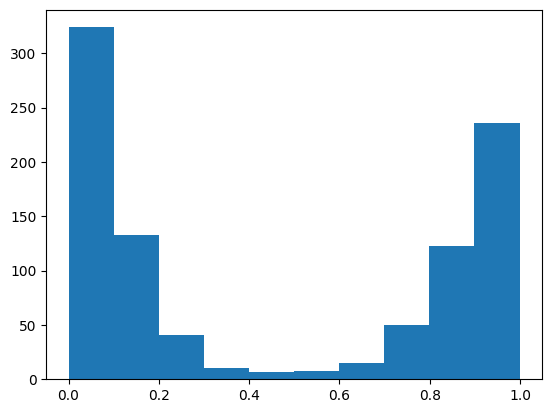

In [76]:
plt.hist(y_train_predrf_classif_proba[:, 1]);

In [38]:
# bring unseed dataset for final test
STOCK_PRICE_PATH_2024 = "../../5min_hist_SPY_2024.csv"
test_stock_price_df = pd.read_csv(STOCK_PRICE_PATH_2024)
test_stock_price_df = test_stock_price_df.sort_values("date").reset_index(drop=True)

In [39]:
test_stock_price_df = ema(test_stock_price_df, 20)
p = 14
test_stock_price_df['rsi_open'] = compute_rsi(test_stock_price_df, "open", p)
test_stock_price_df['rsi_close'] = compute_rsi(test_stock_price_df, "close", p)
fl = 12  # Fast length
sl = 26  # Slow length
test_stock_price_df["macd_hist"] = compute_macd(test_stock_price_df, "open", fl=fl, sl=sl)
# compute elements for the following scopes: 1 hour, 2 hours, 4 hours, 1 day, 2 days, 5 days, 1 week, 2 weeks
scope_list = [
    {"hours": 1},
    {"hours": 2},
    {"hours": 4},
    {"days": 1},
    {"days": 2},
    {"days": 5},
    {"weeks": 1},
    {"weeks": 2}
]
for scp in scope_list:
    test_stock_price_df = compute_future_candles(test_stock_price_df, scope=scp)
all_n_samples = [("1h", 12), ("2h", 12*2), ("4h", 12*4), ("1d", 12*8), ("2d", 12*8*2), ("5d", 12*8*5), ("1w", 12*8*7), ("2w", 12*8*7*2)]
for label, n_samples in all_n_samples:
    for col in ["volume", "rsi_open", "rsi_close", "macd_hist"]:
        test_stock_price_df[f"{label}_{col}_slope"] = compute_slope(test_stock_price_df, col, n_samples)
test_stock_price_df = compute_realized_volat(test_stock_price_df)
test_stock_price_df = stochastic_oscllator(test_stock_price_df)
test_stock_price_df = implied_drift_and_diffusion(test_stock_price_df)
test_stock_price_df = fst_passage_time(test_stock_price_df)
test_stock_price_df = avg_prices(test_stock_price_df)
test_stock_price_df = compute_labels(test_stock_price_df)
test_stock_price_df = stochastic_features(test_stock_price_df)

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/1470572657.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["label_pct_change_last_close_5d_avg_future_max"] = (df["max_future_price_days_5"] / df["close"]) - 1# not close shift since numerator is already the max future price from row + 1
/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/1470572657.py:140: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["label_pct_change_last_close_1w_avg_future_max"] = (df["max_future_price_weeks_1"] / df["

In [40]:
test_stock_price_df = test_stock_price_df.sort_values("date")

label_mask = test_stock_price_df[cols_to_scale + [target_colname]].notna().all(axis=1)
X_future_test_all, y_future_test_all = test_stock_price_df.loc[label_mask, ['date'] + cols_to_scale], test_stock_price_df.loc[label_mask, [target_colname]]

if y_future_test_all[target_colname].dtype not in (int, float, bool):
    if task == "classification":
        y_future_test_all[target_colname] = y_future_test_all[target_colname].astype(int)
    elif task == "regression":
        y_future_test_all[target_colname] = y_future_test_all[target_colname].astype(float)

X_future_test_all, _ = scale_features(X_future_test_all, cols_to_scale, vals_per_col)

In [41]:
X_future_test_calib, y_future_test_calib = Xs3.copy(), ys3.copy()#X_future_test_all.iloc[:cutoff], y_future_test_all.iloc[:cutoff]
X_future_test, y_future_test = X_future_test_all.copy(), y_future_test_all.copy()

In [42]:
# use regression model to predict return

y_predrf_future_calib = rfreg_best_params.predict(X_future_test_calib.drop(columns=["date"]))
y_predrf_future_calib_df = pd.DataFrame(y_predrf_future_calib, index=X_future_test_calib.index, columns=["prediction"])
y_predrf_future_calib_10 = rf_search_10.predict(DMatrix(X_future_test_calib.drop(columns=["date"])))
y_predrf_future_calib_10_df = pd.DataFrame(y_predrf_future_calib_10, index=X_future_test_calib.index, columns=["prediction"])
y_predrf_future_calib_90 = rf_search_90.predict(DMatrix(X_future_test_calib.drop(columns=["date"])))
y_predrf_future_calib_90_df = pd.DataFrame(y_predrf_future_calib_90, index=X_future_test_calib.index, columns=["prediction"])

In [43]:
np.mean((y_future_test_calib[target_colname] >= y_predrf_future_calib_10) & (y_future_test_calib[target_colname] <= y_predrf_future_calib_90)).item().__round__(2)

0.6

Text(0, 0.5, 'predictions')

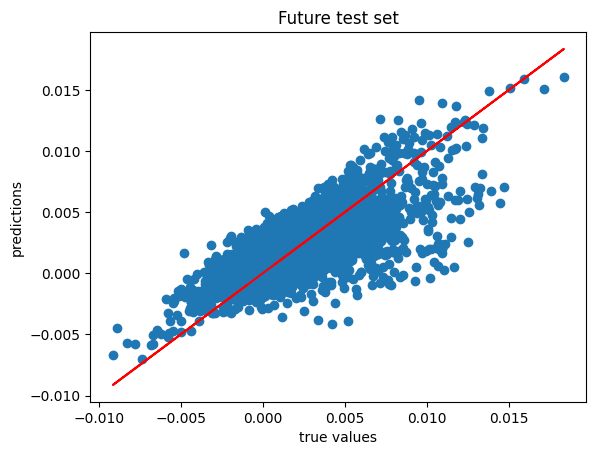

In [44]:
plt.scatter(y_future_test_calib[target_colname], y_predrf_future_calib)
plt.plot(y_future_test_calib[target_colname], y_future_test_calib[target_colname], color="red")
# plt.ylim((0, 0.015))
plt.title("Future test set")
plt.xlabel("true values")
plt.ylabel("predictions")

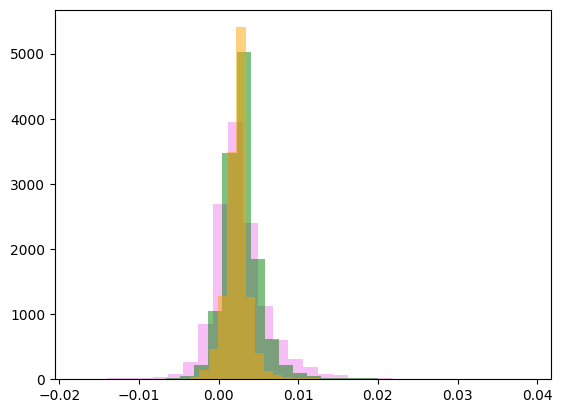

In [45]:
fig, ax = plt.subplots()
ax.hist(ys2[target_colname], bins=30, color="violet", alpha=0.5)
ax.hist(y_predrf, bins=20, color="green", alpha=0.5);
ax.hist(y_predrf_future_calib, bins=20, color="orange", alpha=0.5);

In [46]:
future_condition = y_predrf_future_calib_df["prediction"] > thr

sub_y_predrf_future_calib_df = y_predrf_future_calib_df.loc[future_condition]
sub_y_predrf_future_calib_10_df = y_predrf_future_calib_10_df.loc[future_condition]
sub_y_predrf_future_calib_90_df = y_predrf_future_calib_90_df.loc[future_condition]
X_future_candidates_calib = X_future_test_calib.loc[future_condition]
y_future_candidates_calib = y_future_test_calib.loc[future_condition]

y_future_candidates_calib["label"] = 0
y_future_candidates_calib.loc[sub_y_predrf_future_calib_df["prediction"] <= y_future_candidates_calib[target_colname], "label"] = 1

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/3434037128.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_future_candidates_calib["label"] = 0


In [95]:
# --------------------------------
# --------------------------------
y_future_candidates_calib.loc[sub_y_predrf_future_calib_10_df["prediction"] > 0.007, target_colname].min()

np.float64(0.006168394909427111)

In [ ]:
def compute_quantile_rank(y_pred_new, y_pred_ref):
    y_pred_ref_sorted = np.sort(y_pred_ref)
    return np.searchsorted(y_pred_ref_sorted, y_pred_new, side='right') / len(y_pred_ref)

future_quantile_rank_calib = compute_quantile_rank(y_predrf_future_calib, y_predrf)
future_quantile_rank_calib_df = pd.DataFrame(future_quantile_rank_calib, index=X_future_test_calib.index, columns=["quantile_rank"])
X_future_candidates_calib["orig_prediction"] = y_predrf_future_calib_df["prediction"]
X_future_candidates_calib["quantile_rank"] = future_quantile_rank_calib_df["quantile_rank"]
X_future_candidates_calib["percent_10_vs_avg"] = (sub_y_predrf_future_calib_10_df["prediction"] - y_predrf_future_calib_df["prediction"]) / y_predrf_future_calib_df["prediction"]
X_future_candidates_calib["percent_90_vs_avg"] = (sub_y_predrf_future_calib_90_df["prediction"] - y_predrf_future_calib_df["prediction"]) / y_predrf_future_calib_df["prediction"]

# X_future_candidates_calib["interval_width"] = sub_y_predrf_future_calib_90_df["prediction"] - sub_y_predrf_future_calib_10_df["prediction"]
# X_future_candidates_calib["distance_to_lower"] = y_predrf_future_calib_df["prediction"] - sub_y_predrf_future_calib_10_df["prediction"]
# X_future_candidates_calib["distance_to_upper"] = sub_y_predrf_future_calib_90_df["prediction"] - y_predrf_future_calib_df["prediction"]
# X_future_candidates_calib["quantile_confidence"] = (y_predrf_future_calib_df["prediction"] - sub_y_predrf_future_calib_10_df["prediction"]) / (sub_y_predrf_future_calib_90_df["prediction"] - sub_y_predrf_future_calib_10_df["prediction"])


/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/4258538528.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_future_candidates_calib["orig_prediction"] = y_predrf_future_calib_df["prediction"]
/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/4258538528.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_future_candidates_calib["quantile_rank"] = future_quantile_rank_calib_df["quantile_rank"]
/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/4258538528.py

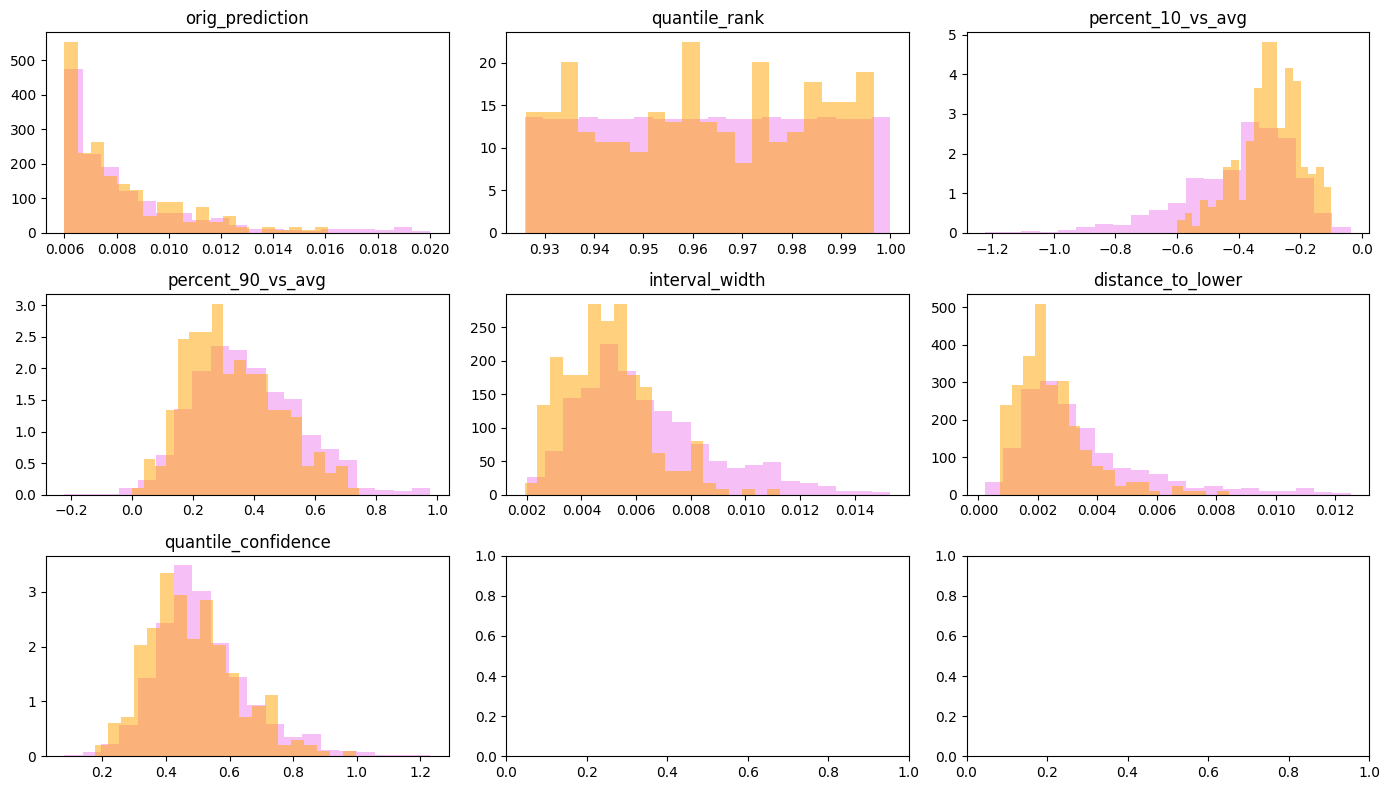

In [48]:
fig, ax = plt.subplots(3, 3, figsize=(14, 8))

ax = ax.flatten()

for i, col in enumerate(
    [
        "orig_prediction",
        "quantile_rank",
        "percent_10_vs_avg",
        "percent_90_vs_avg",
        "interval_width",
        "distance_to_lower",
        "quantile_confidence",
    ]
):

    ax[i].hist(sub_Xs2[col], bins=20, color="violet", label="orig feats", alpha=0.5, density=True)
    ax[i].hist(X_future_candidates_calib[col], bins=20, color="orange", label="calib feats", alpha=0.5, density=True)
    ax[i].set_title(col)

plt.tight_layout()

In [49]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_rfclassif = CalibratedClassifierCV(
    estimator=XGBClassifier(**best_classif_params_),
    method='isotonic',  # or 'sigmoid' for faster/less flexible
    cv=TimeSeriesSplit(n_splits=3),  # Use inner split for calibration
)

calibrated_rfclassif.fit(X_future_candidates_calib.drop(columns=["date"]), y_future_candidates_calib["label"])
y_calib_train_predrf_classif_proba = calibrated_rfclassif.predict_proba(X_future_candidates_calib.drop(columns=["date"]))


In [50]:
print(classification_report(y_future_candidates_calib["label"], y_calib_train_predrf_classif_proba[:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85       176
           1       0.00      0.00      0.00        64

    accuracy                           0.73       240
   macro avg       0.37      0.50      0.42       240
weighted avg       0.54      0.73      0.62       240



/Users/simon/Documents/venvs/options_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/simon/Documents/venvs/options_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/simon/Documents/venvs/options_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

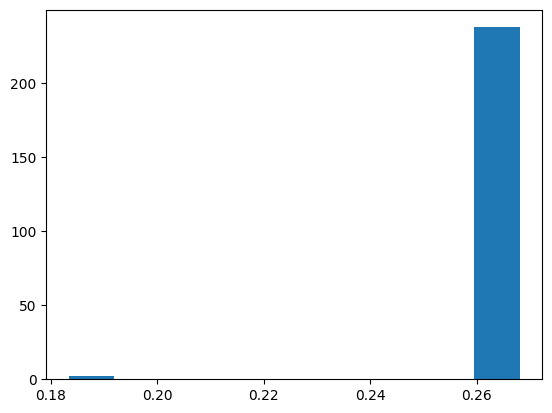

In [303]:
plt.hist(y_calib_train_predrf_classif_proba[:, 1]);

In [51]:
y_predrf_future = rfreg_best_params.predict(X_future_test.drop(columns=["date"]))
y_predrf_future_df = pd.DataFrame(y_predrf_future, index=X_future_test.index, columns=["prediction"])

y_predrf_future_10 = rf_search_10.predict(DMatrix(X_future_test.drop(columns=["date"])))
y_predrf_future_10_df = pd.DataFrame(y_predrf_future_10, index=X_future_test.index, columns=["prediction"])

y_predrf_future_90 = rf_search_90.predict(DMatrix(X_future_test.drop(columns=["date"])))
y_predrf_future_90_df = pd.DataFrame(y_predrf_future_90, index=X_future_test.index, columns=["prediction"])

Text(0, 0.5, 'predictions')

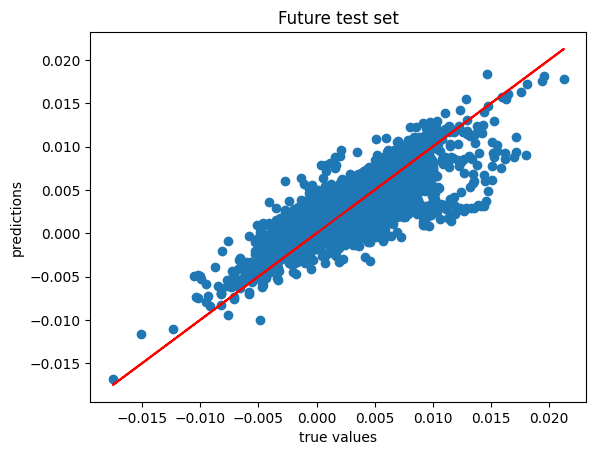

In [52]:
plt.scatter(y_future_test[target_colname], y_predrf_future)
plt.plot(y_future_test[target_colname], y_future_test[target_colname], color="red")
# plt.xlim((-0.010, 0.020))
# plt.ylim((-0.010, 0.020))
plt.title("Future test set")
plt.xlabel("true values")
plt.ylabel("predictions")

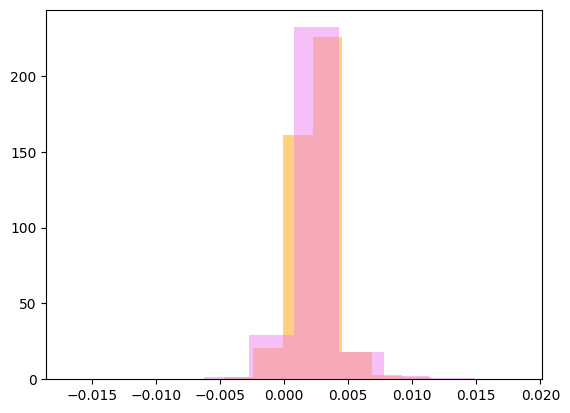

In [306]:
_, ax = plt.subplots()
ax.hist(y_predrf_future_calib, color="orange", alpha=0.5, density=True)
ax.hist(y_predrf_future, color="violet", alpha=0.5, density=True)
None;

In [53]:
future_condition = y_predrf_future_df["prediction"] > thr
sub_y_predrf_future_df = y_predrf_future_df.loc[future_condition]
sub_y_predrf_future_10_df = y_predrf_future_10_df.loc[future_condition]
sub_y_predrf_future_90_df = y_predrf_future_90_df.loc[future_condition]

X_future_candidates = X_future_test.loc[future_condition]
y_future_candidates = y_future_test.loc[future_condition]

y_future_candidates["label"] = 0
y_future_candidates.loc[sub_y_predrf_future_df["prediction"] <= y_future_candidates[target_colname], "label"] = 1

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/2521798585.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_future_candidates["label"] = 0


In [94]:
# --------------------------------
# --------------------------------
y_future_candidates.loc[sub_y_predrf_future_10_df["prediction"] > 0.007, target_colname].min()

np.float64(0.006010091670409112)

<Axes: >

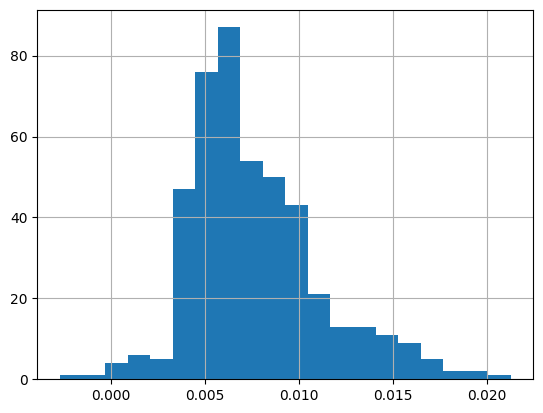

In [308]:
y_future_candidates[target_colname].hist(bins=20)

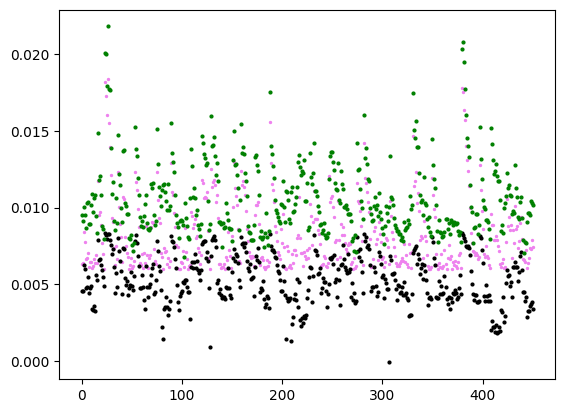

In [54]:
_, ax = plt.subplots()
ax.scatter(range(len(sub_y_predrf_future_df)), sub_y_predrf_future_df, s=2, color="violet")
ax.scatter(range(len(sub_y_predrf_future_10_df)), sub_y_predrf_future_10_df, s=4, color="black")
ax.scatter(range(len(sub_y_predrf_future_90_df)), sub_y_predrf_future_90_df, s=4, color="green")
# sub_y_predrf_future_10_df
# sub_y_predrf_future_90_df

<Axes: >

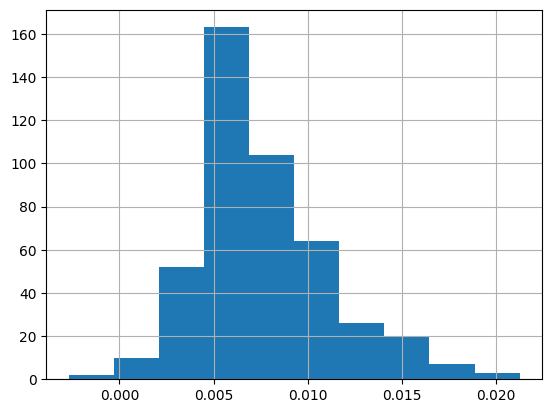

In [310]:
y_future_candidates.loc[sub_y_predrf_future_df["prediction"] > 0.006, target_colname].hist()

In [ ]:
def compute_quantile_rank(y_pred_new, y_pred_ref):
    y_pred_ref_sorted = np.sort(y_pred_ref)
    return np.searchsorted(y_pred_ref_sorted, y_pred_new, side='right') / len(y_pred_ref)

future_quantile_rank = compute_quantile_rank(y_predrf_future, y_predrf)
future_quantile_rank_df = pd.DataFrame(future_quantile_rank, index=X_future_test.index, columns=["quantile_rank"])
X_future_candidates["orig_prediction"] = y_predrf_future_df["prediction"]
X_future_candidates["quantile_rank"] = future_quantile_rank_df["quantile_rank"]
X_future_candidates["percent_10_vs_avg"] = (sub_y_predrf_future_10_df["prediction"] - sub_y_predrf_future_df["prediction"]) / sub_y_predrf_future_df["prediction"]
X_future_candidates["percent_90_vs_avg"] = (sub_y_predrf_future_90_df["prediction"] - sub_y_predrf_future_df["prediction"]) / sub_y_predrf_future_df["prediction"]

# X_future_candidates["interval_width"] = sub_y_predrf_future_90_df["prediction"] - sub_y_predrf_future_10_df["prediction"]
# X_future_candidates["distance_to_lower"] = y_predrf_future_df["prediction"] - sub_y_predrf_future_10_df["prediction"]
# X_future_candidates["distance_to_upper"] = sub_y_predrf_future_90_df["prediction"] - y_predrf_future_df["prediction"]
# X_future_candidates["quantile_confidence"] = (y_predrf_future_df["prediction"] - sub_y_predrf_future_10_df["prediction"]) / (sub_y_predrf_future_90_df["prediction"] - sub_y_predrf_future_10_df["prediction"])


/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/2741154089.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_future_candidates["orig_prediction"] = y_predrf_future_df["prediction"]
/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/2741154089.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_future_candidates["quantile_rank"] = future_quantile_rank_df["quantile_rank"]
/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_58172/2741154089.py:9: SettingWithCopyWarni

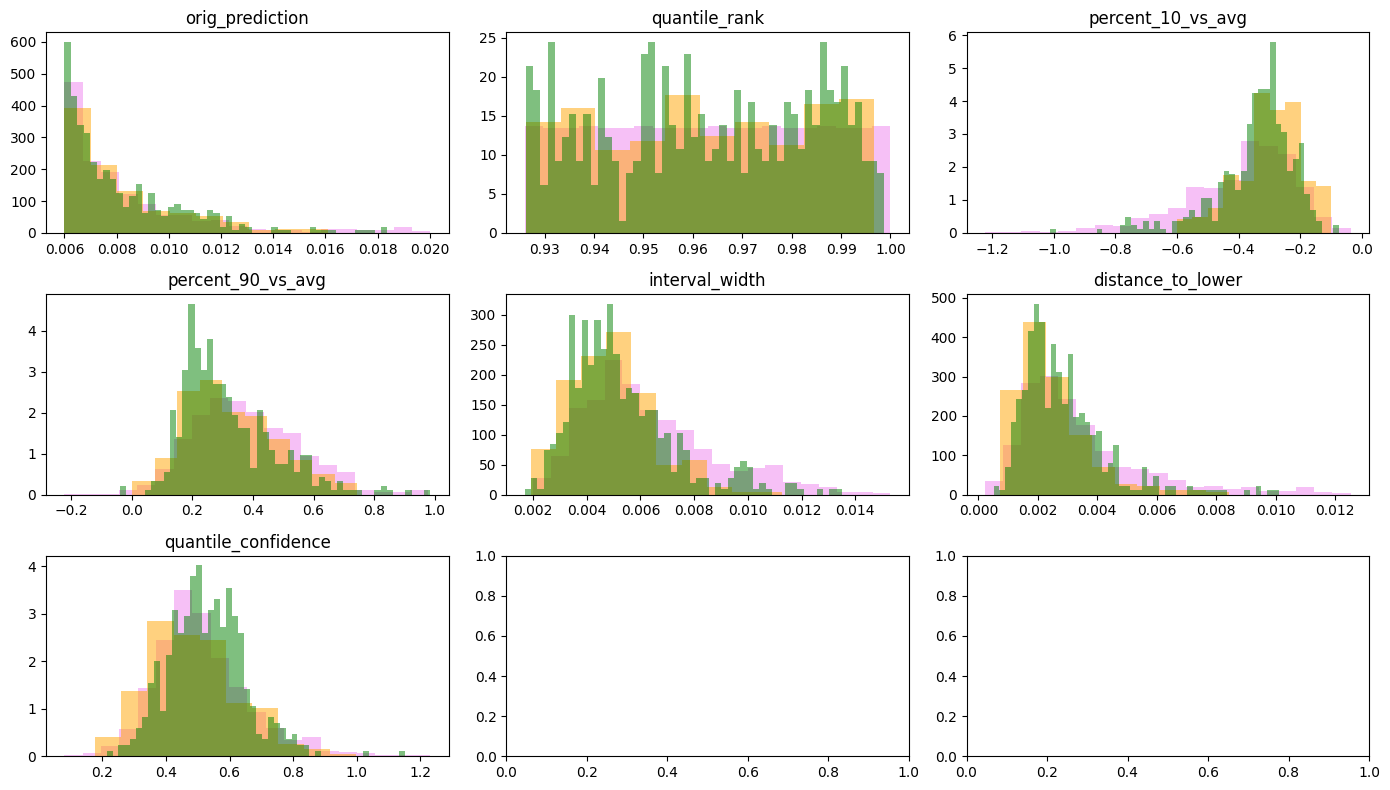

In [56]:
fig, ax = plt.subplots(3, 3, figsize=(14, 8))

ax = ax.flatten()

for i, col in enumerate(
    [
        "orig_prediction",
        "quantile_rank",
        "percent_10_vs_avg",
        "percent_90_vs_avg",
        "interval_width",
        "distance_to_lower",
        "quantile_confidence",
    ]
):
    
    ax[i].hist(sub_Xs2[col], bins=20, color="violet", label="orig feats", alpha=0.5, density=True)
    ax[i].hist(X_future_candidates_calib[col], bins=10, color="orange", label="calib feats", alpha=0.5, density=True)
    ax[i].hist(X_future_candidates[col], bins=50, color="green", label="fut feats", alpha=0.5, density=True)
    ax[i].set_title(col)

plt.tight_layout()

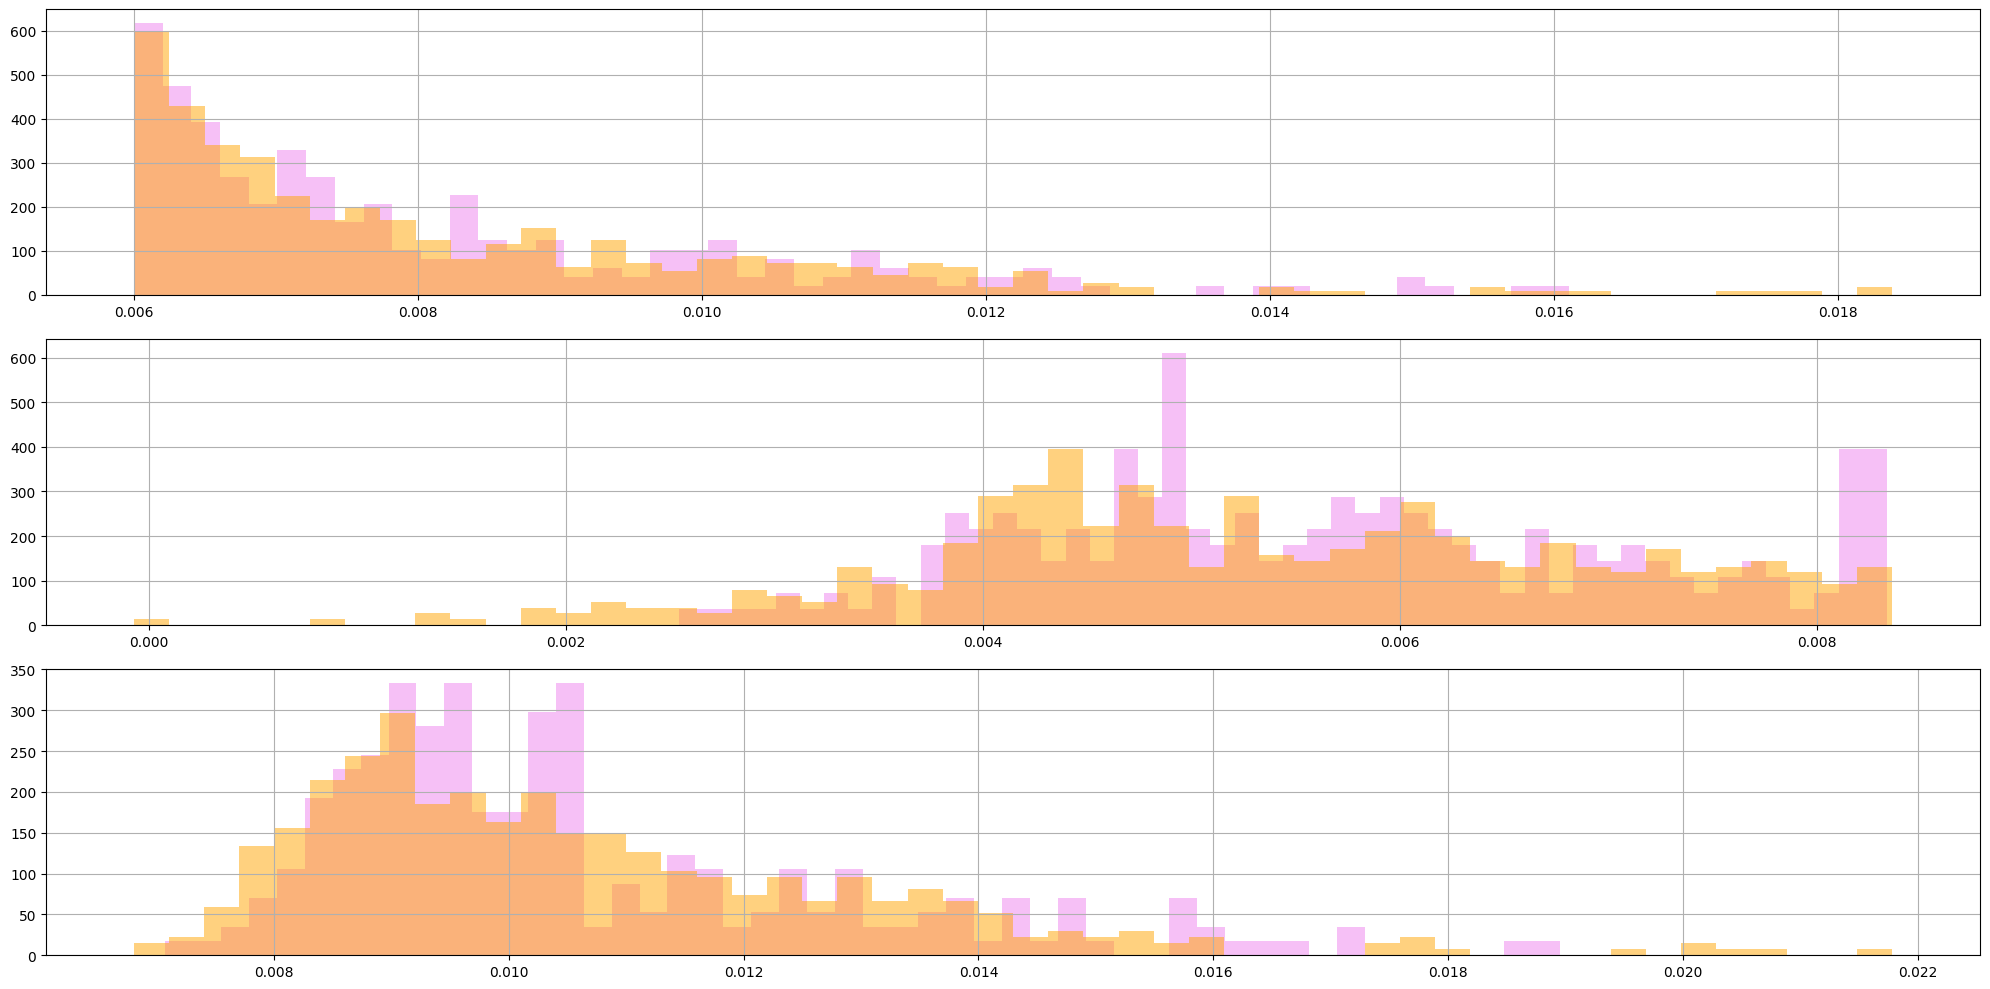

In [57]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
sub_y_predrf_future_calib_df["prediction"].hist(ax=ax[0], bins=50, color='violet', alpha=0.5, label="calib", density=True)
sub_y_predrf_future_df["prediction"].hist(ax=ax[0], bins=50, color='orange', alpha=0.5, label="future", density=True)

sub_y_predrf_future_calib_10_df["prediction"].hist(ax=ax[1], bins=50, color='violet', alpha=0.5, label="calib", density=True)
sub_y_predrf_future_10_df["prediction"].hist(ax=ax[1], bins=50, color='orange', alpha=0.5, label="future", density=True)

sub_y_predrf_future_calib_90_df["prediction"].hist(ax=ax[2], bins=50, color='violet', alpha=0.5, label="calib", density=True)
sub_y_predrf_future_90_df["prediction"].hist(ax=ax[2], bins=50, color='orange', alpha=0.5, label="future", density=True)

plt.tight_layout()
plt.show()

In [58]:
y_future_preds_proba_calib = calibrated_rfclassif.predict_proba(X_future_candidates.drop(columns=["date"]))
y_future_preds = calibrated_rfclassif.predict(X_future_candidates.drop(columns=["date"]))

print(classification_report(y_future_candidates["label"], y_future_preds_proba_calib[:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       306
           1       0.00      0.00      0.00       145

    accuracy                           0.68       451
   macro avg       0.34      0.50      0.40       451
weighted avg       0.46      0.68      0.55       451



/Users/simon/Documents/venvs/options_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/simon/Documents/venvs/options_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/simon/Documents/venvs/options_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [59]:
y_future_preds_proba = rfclassif_search.predict_proba(X_future_candidates.drop(columns=["date"]))
y_future_preds = rfclassif_search.predict(X_future_candidates.drop(columns=["date"]))

print(classification_report(y_future_candidates["label"], y_future_preds_proba[:, 1] > 0.8))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       306
           1       0.47      0.29      0.36       145

    accuracy                           0.67       451
   macro avg       0.59      0.57      0.57       451
weighted avg       0.64      0.67      0.64       451



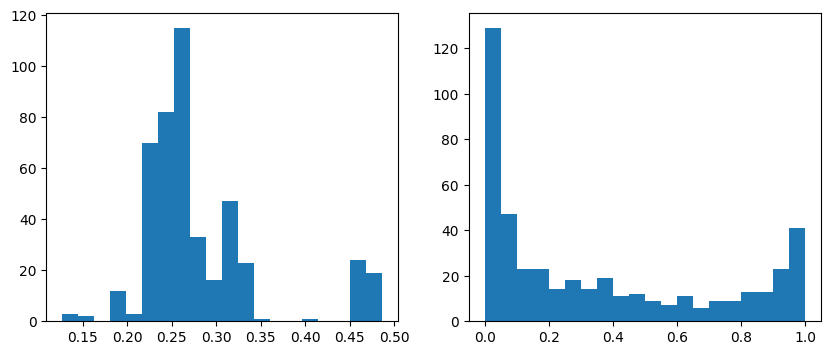

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(y_future_preds_proba_calib[:, 1], bins=20)
ax[1].hist(y_future_preds_proba[:, 1], bins=20);

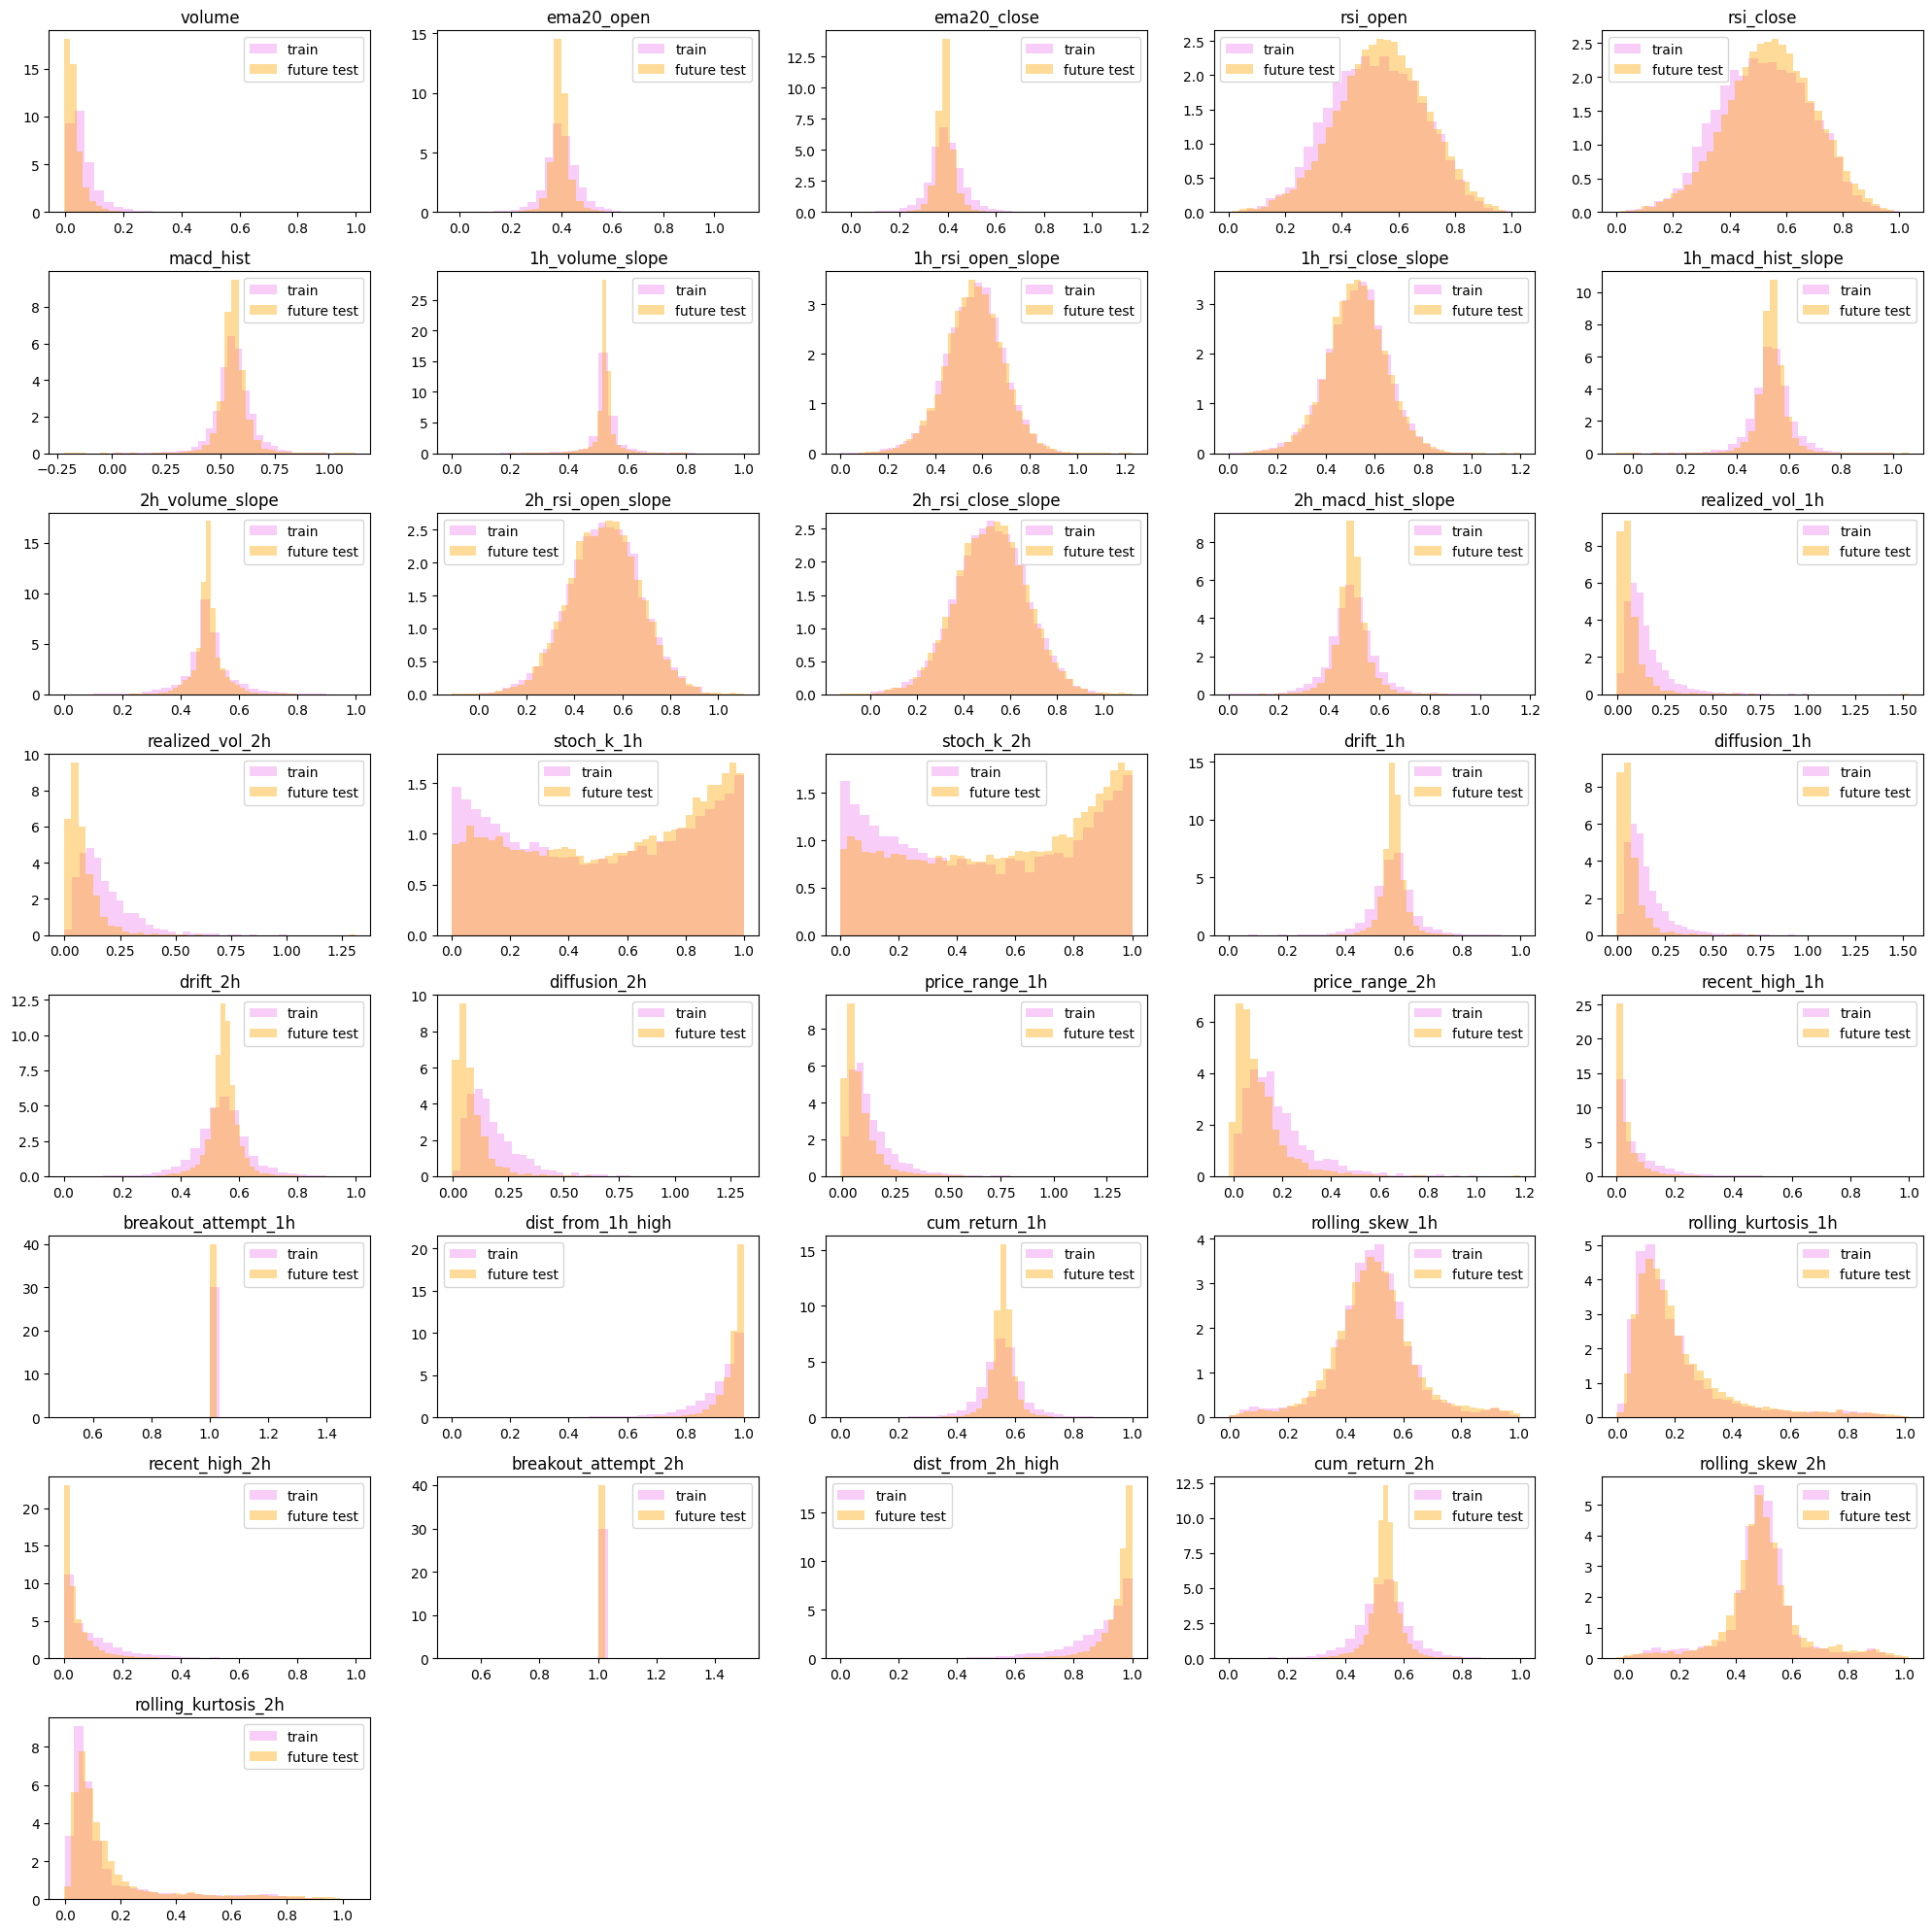

In [148]:
# the predictions of the regressor are poorer in the future test dataset
# let's look at some of the variable distributions to identify potential
# sources of mismatch
# Set up 5x5 grid
fig, axes = plt.subplots(len(cols_to_scale) // 5 + min(1, len(cols_to_scale) % 5), 5, figsize=(20, 20))
axes = axes.flatten()  # Flatten to easily index

# Plot histograms for each column
for i, col in enumerate(cols_to_scale):
    try:
        axes[i].hist(Xs1[col], bins=30, color="violet", alpha=0.4, label="train", density=True)
        # axes[i].hist(Xs2[col], bins=30, color="green", alpha=0.4, label="test", density=True)
        axes[i].hist(X_future_test[col], bins=40, color="orange", alpha=0.4, label="future test", density=True)
        axes[i].set_title(col)
        axes[i].legend()
    except:
        print(col)

# Hide any unused axes
for j in range(len(cols_to_scale), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Think of a strategy

# LONG trend
# use data from S1 2023 for training and S2 for testing. If coherent use data from 2024 for further testing

# SHORT trend
# carry out same methodology than LONG trend.

# CHECK trends
# check whether model predicts both up and down trend and evaluate what is more likely to have a more accurate estimation